In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import torch # not used

[WARN] no Optuna JSON found for 'AAPL' in 'optuna_results', using defaults


In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


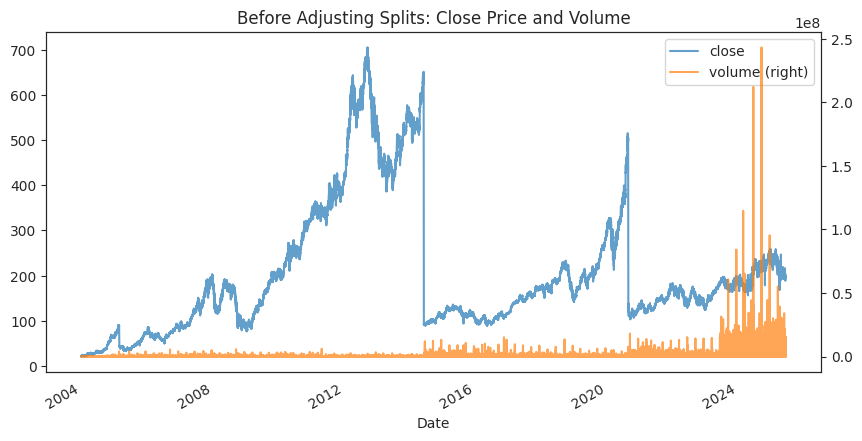

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


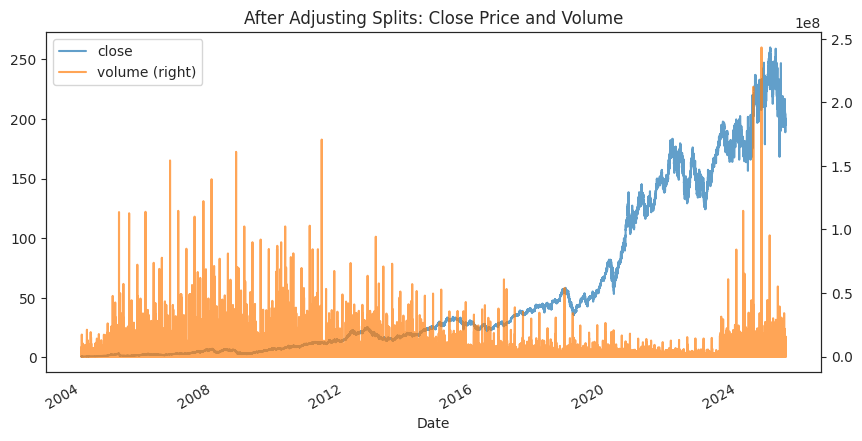

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile,
    smoothing_window
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',

        # — Trade-ID parameters —
        min_prof_thr             = min_prof_thr,            # profit % threshold (profit_pc ≥ min_prof_thr),  
                                                             # e.g. 0.5 → require at least 0.5% gain  
        max_down_prop            = max_down_prop,           # max retracement **fraction** of that profit range before exit,  
                                                             # e.g. 0.2 → allow up to 20% retracement of your gain  
        gain_tightening_factor   = gain_tightening_factor,  # dimensionless factor that tightens max_down_prop per %-gain,  
                                                             # applied as base/(1 + factor×gain%)  
        merging_retracement_thr  = merging_retracement_thr, # intermediate retracement **ratio** to merge two trades,  
                                                             # e.g. 0.3 → allow up to a 30% pullback of trade1’s range  
        merging_time_gap_thr     = merging_time_gap_thr,    # time-gap **ratio** to merge two trades,  
                                                             # gap_sec/(duration1+duration2), dimensionless  
    
        # — Continuous-signal parameters —
        pre_entry_decay          = pre_entry_decay,         # per-minute decay rate on pre-entry signal (0–1),  
                                                             # lower≈0.01→slow fade, higher≈0.1→fast fade  
        short_penal_decay        = short_penal_decay,       # exponent penalty on short-trade durations,  
                                                             # >1 amplifies suppression of very short signals  
    
        # — Final-trigger parameters —
        trailing_stop_pct        = trailing_stop_pct,       # trailing-stop distance **percent**,  
                                                             # internally divided by 100,  
                                                             # e.g. 0.5 → 0.5% stop loss  
        buy_threshold            = buy_threshold,           # normalized signal threshold ∈[0,1] to enter trade,  
                                                             # e.g. 0.5 → require 50% signal  
        top_percentile           = top_percentile,           # percentile **percent** to cap signal at 1.0,  
                                                             # e.g. 1.0 → top 1% of raw signals become 1.0  
        smoothing_window         = smoothing_window
    )


    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.05), # increasing min to 0.03, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.6),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 3, 9),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.2, 0.6),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 2, 5),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.03, 0.09), # decreasing max to 0.05, to avoid too fast trading
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 3, 6),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.7), # increasing min to 0.03, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.3, 0.6),
        "top_percentile"          : trial.suggest_float("top_percentile", 3, 5),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [5])
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-09-01 09:10:31,691] A new study created in RDB with name: no-name-33dcac40-1256-4a48-86bf-0a4b0b0bdca7


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [05:19<00:00, 16.92day/s]
[I 2025-09-01 09:16:19,087] Trial 0 finished with value: 0.1896122222222222 and parameters: {'min_prof_thr': 0.03329486907379811, 'max_down_prop': 0.11603574073184172, 'gain_tightening_factor': 3.972509037229221, 'merging_retracement_thr': 0.5782720024969652, 'merging_time_gap_thr': 2.9816233082396937, 'pre_entry_decay': 0.03506939214020452, 'short_penal_decay': 3.754576966440321, 'trailing_stop_pct': 0.6048089242625699, 'buy_threshold': 0.352723945042319, 'top_percentile': 3.87459125269121, 'smoothing_window': 5}. Best is trial 0 with value: 0.1896122222222222.


→ Total return across 5400 trading days: $1023.91
→ Avg daily return (all days)          : $0.1896
→ Total trades                          : 13325
→ Avg return per trade                  : $0.0768



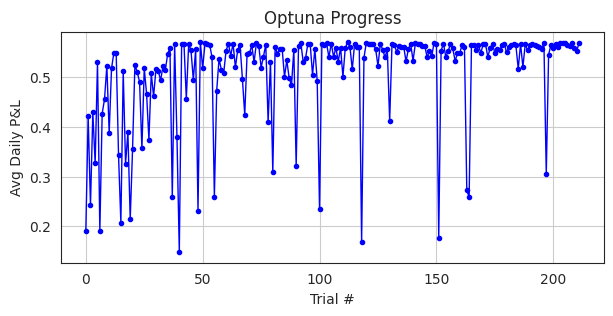

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:11<00:00, 21.46day/s]
[I 2025-09-01 09:21:07,714] Trial 1 finished with value: 0.4214948148148148 and parameters: {'min_prof_thr': 0.04075615117507025, 'max_down_prop': 0.4432730518628035, 'gain_tightening_factor': 6.71729557132955, 'merging_retracement_thr': 0.3376384447164487, 'merging_time_gap_thr': 4.191738153182061, 'pre_entry_decay': 0.04962002120818046, 'short_penal_decay': 5.874738296230228, 'trailing_stop_pct': 0.14825948754732077, 'buy_threshold': 0.33153124292601205, 'top_percentile': 4.957903669485365, 'smoothing_window': 5}. Best is trial 1 with value: 0.4214948148148148.


→ Total return across 5400 trading days: $2276.07
→ Avg daily return (all days)          : $0.4215
→ Total trades                          : 29363
→ Avg return per trade                  : $0.0775

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:01<00:00, 22.37day/s]
[I 2025-09-01 09:25:49,734] Trial 2 finished with value: 0.2425142592592592 and parameters: {'min_prof_thr': 0.016386558808212846, 'max_down_prop': 0.3398184078961699, 'gain_tightening_factor': 4.649450451279326, 'merging_retracement_thr': 0.46550315762267347, 'merging_time_gap_thr': 2.140688468462023, 'pre_entry_decay': 0.08685446434314407, 'short_penal_decay': 5.66927477063572, 'trailing_stop_pct': 0.4329301071380518, 'buy_threshold': 0.3828674732285895, 'top_percentile': 3.6076655851820885, 'smoothing_window': 5}. Best is trial 1 with value: 0.4214948148148148.


→ Total return across 5400 trading days: $1309.58
→ Avg daily return (all days)          : $0.2425
→ Total trades                          : 19521
→ Avg return per trade                  : $0.0671

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:05<00:00, 21.97day/s]
[I 2025-09-01 09:30:31,625] Trial 3 finished with value: 0.42875314814814813 and parameters: {'min_prof_thr': 0.02969898369237791, 'max_down_prop': 0.18734760411388937, 'gain_tightening_factor': 5.51997050971764, 'merging_retracement_thr': 0.3588904048794496, 'merging_time_gap_thr': 3.687741969862942, 'pre_entry_decay': 0.03403870760666454, 'short_penal_decay': 4.729819547386677, 'trailing_stop_pct': 0.19431811700257778, 'buy_threshold': 0.3367447265604772, 'top_percentile': 3.996526707283563, 'smoothing_window': 5}. Best is trial 3 with value: 0.42875314814814813.


→ Total return across 5400 trading days: $2315.27
→ Avg daily return (all days)          : $0.4288
→ Total trades                          : 23596
→ Avg return per trade                  : $0.0981

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:59<00:00, 22.58day/s]
[I 2025-09-01 09:35:07,154] Trial 4 finished with value: 0.3261759259259259 and parameters: {'min_prof_thr': 0.018312402938917574, 'max_down_prop': 0.556362338659573, 'gain_tightening_factor': 8.649076828629845, 'merging_retracement_thr': 0.4844466088650243, 'merging_time_gap_thr': 3.1400369834320143, 'pre_entry_decay': 0.043324721612921294, 'short_penal_decay': 3.876590142744557, 'trailing_stop_pct': 0.4244393413527062, 'buy_threshold': 0.49664720347777735, 'top_percentile': 3.924148759994464, 'smoothing_window': 5}. Best is trial 3 with value: 0.42875314814814813.


→ Total return across 5400 trading days: $1761.35
→ Avg daily return (all days)          : $0.3262
→ Total trades                          : 15921
→ Avg return per trade                  : $0.1106

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.14day/s]
[I 2025-09-01 09:38:31,281] Trial 5 finished with value: 0.5298157407407408 and parameters: {'min_prof_thr': 0.02567765748490513, 'max_down_prop': 0.35823451022083275, 'gain_tightening_factor': 6.5075845237696734, 'merging_retracement_thr': 0.4138973221329089, 'merging_time_gap_thr': 3.5035325724926043, 'pre_entry_decay': 0.035953486669430816, 'short_penal_decay': 3.9380685507560993, 'trailing_stop_pct': 0.10340737744414322, 'buy_threshold': 0.5008070971990876, 'top_percentile': 4.177926647654709, 'smoothing_window': 5}. Best is trial 5 with value: 0.5298157407407408.


→ Total return across 5400 trading days: $2861.01
→ Avg daily return (all days)          : $0.5298
→ Total trades                          : 22245
→ Avg return per trade                  : $0.1286

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.82day/s]
[I 2025-09-01 09:41:30,991] Trial 6 finished with value: 0.19000092592592593 and parameters: {'min_prof_thr': 0.03882075678550709, 'max_down_prop': 0.15529214396840127, 'gain_tightening_factor': 6.588434490201163, 'merging_retracement_thr': 0.3216564045936361, 'merging_time_gap_thr': 4.396241242093938, 'pre_entry_decay': 0.06664930665037636, 'short_penal_decay': 4.869241242465673, 'trailing_stop_pct': 0.6472943203739555, 'buy_threshold': 0.3761280490402174, 'top_percentile': 3.325291158402208, 'smoothing_window': 5}. Best is trial 5 with value: 0.5298157407407408.


→ Total return across 5400 trading days: $1026.01
→ Avg daily return (all days)          : $0.1900
→ Total trades                          : 13621
→ Avg return per trade                  : $0.0753

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.83day/s]
[I 2025-09-01 09:44:23,724] Trial 7 finished with value: 0.42663240740740743 and parameters: {'min_prof_thr': 0.03566245660131816, 'max_down_prop': 0.4748838071481123, 'gain_tightening_factor': 5.077870552468175, 'merging_retracement_thr': 0.3504098073663986, 'merging_time_gap_thr': 3.0967852840396937, 'pre_entry_decay': 0.033599332269585114, 'short_penal_decay': 4.151534789402619, 'trailing_stop_pct': 0.252407355515326, 'buy_threshold': 0.465717144804169, 'top_percentile': 4.240451496634672, 'smoothing_window': 5}. Best is trial 5 with value: 0.5298157407407408.


→ Total return across 5400 trading days: $2303.82
→ Avg daily return (all days)          : $0.4266
→ Total trades                          : 18723
→ Avg return per trade                  : $0.1230

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.45day/s]
[I 2025-09-01 09:47:17,489] Trial 8 finished with value: 0.45517814814814817 and parameters: {'min_prof_thr': 0.011766656231880654, 'max_down_prop': 0.5543386621025106, 'gain_tightening_factor': 4.022160563778954, 'merging_retracement_thr': 0.2351710779725297, 'merging_time_gap_thr': 2.5836500314193342, 'pre_entry_decay': 0.08161676836677828, 'short_penal_decay': 3.1557409987890583, 'trailing_stop_pct': 0.11145863626819817, 'buy_threshold': 0.5091952207461719, 'top_percentile': 4.456874515131386, 'smoothing_window': 5}. Best is trial 5 with value: 0.5298157407407408.


→ Total return across 5400 trading days: $2457.96
→ Avg daily return (all days)          : $0.4552
→ Total trades                          : 33790
→ Avg return per trade                  : $0.0727

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.37day/s]
[I 2025-09-01 09:50:12,367] Trial 9 finished with value: 0.5222081481481482 and parameters: {'min_prof_thr': 0.026190933779221763, 'max_down_prop': 0.18763726857311488, 'gain_tightening_factor': 5.328897442791664, 'merging_retracement_thr': 0.41044159132641966, 'merging_time_gap_thr': 2.535973025793453, 'pre_entry_decay': 0.03835549879155421, 'short_penal_decay': 3.812454182394717, 'trailing_stop_pct': 0.06442734746438075, 'buy_threshold': 0.3616075151304626, 'top_percentile': 4.527514508368707, 'smoothing_window': 5}. Best is trial 5 with value: 0.5298157407407408.


→ Total return across 5400 trading days: $2819.92
→ Avg daily return (all days)          : $0.5222
→ Total trades                          : 32154
→ Avg return per trade                  : $0.0877

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.73day/s]
[I 2025-09-01 09:53:10,983] Trial 10 finished with value: 0.38804129629629636 and parameters: {'min_prof_thr': 0.024527001841844382, 'max_down_prop': 0.29936116409826063, 'gain_tightening_factor': 7.765052272616398, 'merging_retracement_thr': 0.20140836123288025, 'merging_time_gap_thr': 4.898976776240171, 'pre_entry_decay': 0.05832714596288862, 'short_penal_decay': 3.081147892962202, 'trailing_stop_pct': 0.3070772464213555, 'buy_threshold': 0.5946784142892353, 'top_percentile': 3.0084098766582965, 'smoothing_window': 5}. Best is trial 5 with value: 0.5298157407407408.


→ Total return across 5400 trading days: $2095.42
→ Avg daily return (all days)          : $0.3880
→ Total trades                          : 15924
→ Avg return per trade                  : $0.1316

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.18day/s]
[I 2025-09-01 09:55:59,970] Trial 11 finished with value: 0.5172292592592592 and parameters: {'min_prof_thr': 0.04715033144040137, 'max_down_prop': 0.2530969999167599, 'gain_tightening_factor': 6.250541031494575, 'merging_retracement_thr': 0.44176757118934357, 'merging_time_gap_thr': 3.7374791001383554, 'pre_entry_decay': 0.04682512105052031, 'short_penal_decay': 3.52014258369341, 'trailing_stop_pct': 0.03991597354316899, 'buy_threshold': 0.5570742620545754, 'top_percentile': 4.643432721181305, 'smoothing_window': 5}. Best is trial 5 with value: 0.5298157407407408.


→ Total return across 5400 trading days: $2793.04
→ Avg daily return (all days)          : $0.5172
→ Total trades                          : 25679
→ Avg return per trade                  : $0.1088

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.66day/s]
[I 2025-09-01 09:58:52,589] Trial 12 finished with value: 0.5485462962962964 and parameters: {'min_prof_thr': 0.0251170775273926, 'max_down_prop': 0.4046961728426214, 'gain_tightening_factor': 7.253853808888409, 'merging_retracement_thr': 0.543261754787655, 'merging_time_gap_thr': 2.297683643786594, 'pre_entry_decay': 0.059354743942203664, 'short_penal_decay': 4.373228257267515, 'trailing_stop_pct': 0.04701982471294977, 'buy_threshold': 0.4138909864097735, 'top_percentile': 4.417032020560271, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2962.15
→ Avg daily return (all days)          : $0.5485
→ Total trades                          : 34967
→ Avg return per trade                  : $0.0847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.24day/s]
[I 2025-09-01 10:01:51,371] Trial 13 finished with value: 0.5477075925925927 and parameters: {'min_prof_thr': 0.023541410340717394, 'max_down_prop': 0.41838297874891184, 'gain_tightening_factor': 7.488005883379508, 'merging_retracement_thr': 0.5773716802690712, 'merging_time_gap_thr': 2.0623557119908082, 'pre_entry_decay': 0.06787351602707457, 'short_penal_decay': 4.348553268438549, 'trailing_stop_pct': 0.03098347834271341, 'buy_threshold': 0.4185742045434362, 'top_percentile': 4.2663386948202415, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2957.62
→ Avg daily return (all days)          : $0.5477
→ Total trades                          : 36766
→ Avg return per trade                  : $0.0804

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 33.98day/s]
[I 2025-09-01 10:04:54,663] Trial 14 finished with value: 0.34248999999999996 and parameters: {'min_prof_thr': 0.020193304797836015, 'max_down_prop': 0.4309328796649814, 'gain_tightening_factor': 7.537305377119207, 'merging_retracement_thr': 0.5719166701421128, 'merging_time_gap_thr': 2.0448275512713794, 'pre_entry_decay': 0.07060215201629934, 'short_penal_decay': 5.160101279040124, 'trailing_stop_pct': 0.23215992627257354, 'buy_threshold': 0.41416110427023517, 'top_percentile': 4.869777241643918, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $1849.45
→ Avg daily return (all days)          : $0.3425
→ Total trades                          : 27887
→ Avg return per trade                  : $0.0663

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.35day/s]
[I 2025-09-01 10:07:53,812] Trial 15 finished with value: 0.2072538888888889 and parameters: {'min_prof_thr': 0.02121364368580888, 'max_down_prop': 0.3919675544221015, 'gain_tightening_factor': 8.819886240479608, 'merging_retracement_thr': 0.535501918912759, 'merging_time_gap_thr': 2.4348400792019964, 'pre_entry_decay': 0.06117432507042198, 'short_penal_decay': 4.351357995247534, 'trailing_stop_pct': 0.5483445384469136, 'buy_threshold': 0.42125696307195115, 'top_percentile': 4.304192005193606, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $1119.17
→ Avg daily return (all days)          : $0.2073
→ Total trades                          : 15639
→ Avg return per trade                  : $0.0716

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.55day/s]
[I 2025-09-01 10:10:57,606] Trial 16 finished with value: 0.5119622222222222 and parameters: {'min_prof_thr': 0.012068977415459805, 'max_down_prop': 0.49073329818991884, 'gain_tightening_factor': 7.459523969773334, 'merging_retracement_thr': 0.5173052095334396, 'merging_time_gap_thr': 2.7526682099855617, 'pre_entry_decay': 0.07360060752642947, 'short_penal_decay': 5.227254054689437, 'trailing_stop_pct': 0.03382687117286464, 'buy_threshold': 0.30301904916259814, 'top_percentile': 4.661461133072896, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2764.60
→ Avg daily return (all days)          : $0.5120
→ Total trades                          : 45125
→ Avg return per trade                  : $0.0613

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.13day/s]
[I 2025-09-01 10:13:59,542] Trial 17 finished with value: 0.3256718518518518 and parameters: {'min_prof_thr': 0.029735550331117667, 'max_down_prop': 0.2786685307061166, 'gain_tightening_factor': 8.126841346347108, 'merging_retracement_thr': 0.598242361134202, 'merging_time_gap_thr': 2.228523992929284, 'pre_entry_decay': 0.05400430483661956, 'short_penal_decay': 4.534984739791997, 'trailing_stop_pct': 0.33691677925408936, 'buy_threshold': 0.43358616904290553, 'top_percentile': 3.653532213080916, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $1758.63
→ Avg daily return (all days)          : $0.3257
→ Total trades                          : 20123
→ Avg return per trade                  : $0.0874

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.05day/s]
[I 2025-09-01 10:16:51,355] Trial 18 finished with value: 0.3886142592592593 and parameters: {'min_prof_thr': 0.015459823286018134, 'max_down_prop': 0.5125387237261434, 'gain_tightening_factor': 3.0877501214432366, 'merging_retracement_thr': 0.525391327803935, 'merging_time_gap_thr': 2.0140417656224647, 'pre_entry_decay': 0.07746180527001084, 'short_penal_decay': 4.225837293795526, 'trailing_stop_pct': 0.1683819476398281, 'buy_threshold': 0.4620716118279625, 'top_percentile': 4.342654552121887, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2098.52
→ Avg daily return (all days)          : $0.3886
→ Total trades                          : 30473
→ Avg return per trade                  : $0.0689

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.34day/s]
[I 2025-09-01 10:19:48,862] Trial 19 finished with value: 0.21412074074074072 and parameters: {'min_prof_thr': 0.022288143278941012, 'max_down_prop': 0.39944171524188743, 'gain_tightening_factor': 7.221316004122721, 'merging_retracement_thr': 0.5487478232597301, 'merging_time_gap_thr': 2.841770516313794, 'pre_entry_decay': 0.06491252143614192, 'short_penal_decay': 5.037897441340937, 'trailing_stop_pct': 0.4795921810665132, 'buy_threshold': 0.40173151533949925, 'top_percentile': 4.753688099495495, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $1156.25
→ Avg daily return (all days)          : $0.2141
→ Total trades                          : 17574
→ Avg return per trade                  : $0.0658

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.60day/s]
[I 2025-09-01 10:22:45,163] Trial 20 finished with value: 0.35531740740740747 and parameters: {'min_prof_thr': 0.04530388222595319, 'max_down_prop': 0.5967133706329238, 'gain_tightening_factor': 8.30418737319346, 'merging_retracement_thr': 0.4894066476193153, 'merging_time_gap_thr': 2.385012680212351, 'pre_entry_decay': 0.05800244609336062, 'short_penal_decay': 4.572149093932208, 'trailing_stop_pct': 0.25364841626737433, 'buy_threshold': 0.4598199192191893, 'top_percentile': 4.116238539940251, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $1918.71
→ Avg daily return (all days)          : $0.3553
→ Total trades                          : 23193
→ Avg return per trade                  : $0.0827

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.84day/s]
[I 2025-09-01 10:25:43,129] Trial 21 finished with value: 0.5242957407407408 and parameters: {'min_prof_thr': 0.026766612628713136, 'max_down_prop': 0.3546971918311473, 'gain_tightening_factor': 6.929818560258138, 'merging_retracement_thr': 0.27844698152630093, 'merging_time_gap_thr': 3.3883124848887403, 'pre_entry_decay': 0.05212719452691435, 'short_penal_decay': 4.12120676571466, 'trailing_stop_pct': 0.08988771853853571, 'buy_threshold': 0.5349472627407924, 'top_percentile': 4.154805425621144, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2831.20
→ Avg daily return (all days)          : $0.5243
→ Total trades                          : 23797
→ Avg return per trade                  : $0.1190

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.32day/s]
[I 2025-09-01 10:28:52,309] Trial 22 finished with value: 0.5099327777777778 and parameters: {'min_prof_thr': 0.03273300137668464, 'max_down_prop': 0.34429925858594623, 'gain_tightening_factor': 6.3796145209027015, 'merging_retracement_thr': 0.40867396735250044, 'merging_time_gap_thr': 3.869733181242976, 'pre_entry_decay': 0.04100323048821244, 'short_penal_decay': 3.4890817908106992, 'trailing_stop_pct': 0.12950404837422036, 'buy_threshold': 0.49216162522361134, 'top_percentile': 3.7643761729822005, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2753.64
→ Avg daily return (all days)          : $0.5099
→ Total trades                          : 22661
→ Avg return per trade                  : $0.1215

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.51day/s]
[I 2025-09-01 10:32:04,630] Trial 23 finished with value: 0.49023740740740746 and parameters: {'min_prof_thr': 0.024484851864993367, 'max_down_prop': 0.3897980151478283, 'gain_tightening_factor': 5.993589137978796, 'merging_retracement_thr': 0.4611040867125578, 'merging_time_gap_thr': 3.3429858670886428, 'pre_entry_decay': 0.07009648453169873, 'short_penal_decay': 3.919505590698834, 'trailing_stop_pct': 0.0942279823727787, 'buy_threshold': 0.4370162605406967, 'top_percentile': 4.4808355447339006, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2647.28
→ Avg daily return (all days)          : $0.4902
→ Total trades                          : 34445
→ Avg return per trade                  : $0.0769

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 31.99day/s]
[I 2025-09-01 10:35:16,861] Trial 24 finished with value: 0.35669703703703703 and parameters: {'min_prof_thr': 0.028390703115641132, 'max_down_prop': 0.4394501226450509, 'gain_tightening_factor': 5.843423130377765, 'merging_retracement_thr': 0.5067369142042943, 'merging_time_gap_thr': 3.9734648884992856, 'pre_entry_decay': 0.08842941057461391, 'short_penal_decay': 4.397342746979837, 'trailing_stop_pct': 0.20560940362590632, 'buy_threshold': 0.5280610126800743, 'top_percentile': 4.114423343150262, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $1926.16
→ Avg daily return (all days)          : $0.3567
→ Total trades                          : 26895
→ Avg return per trade                  : $0.0716

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.63day/s]
[I 2025-09-01 10:38:25,286] Trial 25 finished with value: 0.5175575925925926 and parameters: {'min_prof_thr': 0.023465320972273176, 'max_down_prop': 0.31838847458093555, 'gain_tightening_factor': 7.942847608171929, 'merging_retracement_thr': 0.5653526634450513, 'merging_time_gap_thr': 3.552573042354715, 'pre_entry_decay': 0.07784860466520876, 'short_penal_decay': 3.6081934397657616, 'trailing_stop_pct': 0.03362820153842659, 'buy_threshold': 0.3946439976040417, 'top_percentile': 4.334247771123443, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2794.81
→ Avg daily return (all days)          : $0.5176
→ Total trades                          : 42220
→ Avg return per trade                  : $0.0662

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.50day/s]
[I 2025-09-01 10:41:25,286] Trial 26 finished with value: 0.46640518518518514 and parameters: {'min_prof_thr': 0.032539313569020664, 'max_down_prop': 0.22666757640425164, 'gain_tightening_factor': 7.182062646036175, 'merging_retracement_thr': 0.3802433701615626, 'merging_time_gap_thr': 2.2770867453263683, 'pre_entry_decay': 0.062836281886579, 'short_penal_decay': 4.709260723341697, 'trailing_stop_pct': 0.141425382027261, 'buy_threshold': 0.4809123572097365, 'top_percentile': 4.476272871512718, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2518.59
→ Avg daily return (all days)          : $0.4664
→ Total trades                          : 27110
→ Avg return per trade                  : $0.0929

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.06day/s]
[I 2025-09-01 10:44:24,861] Trial 27 finished with value: 0.3740346296296297 and parameters: {'min_prof_thr': 0.01720594876778124, 'max_down_prop': 0.36918933139757226, 'gain_tightening_factor': 6.922501270340292, 'merging_retracement_thr': 0.4300146735564983, 'merging_time_gap_thr': 2.718251839817004, 'pre_entry_decay': 0.05613842315138501, 'short_penal_decay': 4.015433830223239, 'trailing_stop_pct': 0.29384084360522106, 'buy_threshold': 0.4498075366904151, 'top_percentile': 3.4463292735941247, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2019.79
→ Avg daily return (all days)          : $0.3740
→ Total trades                          : 20921
→ Avg return per trade                  : $0.0965

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.17day/s]
[I 2025-09-01 10:47:23,625] Trial 28 finished with value: 0.5071374074074074 and parameters: {'min_prof_thr': 0.020186689029996447, 'max_down_prop': 0.41660583351111385, 'gain_tightening_factor': 7.524720037716139, 'merging_retracement_thr': 0.5996938498325771, 'merging_time_gap_thr': 4.536373676738086, 'pre_entry_decay': 0.03001946104701652, 'short_penal_decay': 3.2798493186602093, 'trailing_stop_pct': 0.08728540068061168, 'buy_threshold': 0.5570887719094302, 'top_percentile': 4.067752607804467, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2738.54
→ Avg daily return (all days)          : $0.5071
→ Total trades                          : 19575
→ Avg return per trade                  : $0.1399

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.08day/s]
[I 2025-09-01 10:50:19,139] Trial 29 finished with value: 0.4609225925925926 and parameters: {'min_prof_thr': 0.035077132049034135, 'max_down_prop': 0.4747945507355709, 'gain_tightening_factor': 8.427002274313876, 'merging_retracement_thr': 0.5551928176807917, 'merging_time_gap_thr': 3.022721439215555, 'pre_entry_decay': 0.04592925456414407, 'short_penal_decay': 5.355771238763184, 'trailing_stop_pct': 0.17836341677610767, 'buy_threshold': 0.42652209412585634, 'top_percentile': 3.8183224127337745, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2488.98
→ Avg daily return (all days)          : $0.4609
→ Total trades                          : 23807
→ Avg return per trade                  : $0.1045

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.41day/s]
[I 2025-09-01 10:53:13,812] Trial 30 finished with value: 0.5153494444444445 and parameters: {'min_prof_thr': 0.02544515174941447, 'max_down_prop': 0.313456970084494, 'gain_tightening_factor': 6.414728108740684, 'merging_retracement_thr': 0.2897714218469235, 'merging_time_gap_thr': 3.2411265170764576, 'pre_entry_decay': 0.08087202185553982, 'short_penal_decay': 3.6647179171711497, 'trailing_stop_pct': 0.07306498739932765, 'buy_threshold': 0.4770632502530612, 'top_percentile': 4.2192972116049114, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2782.89
→ Avg daily return (all days)          : $0.5153
→ Total trades                          : 33929
→ Avg return per trade                  : $0.0820

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.82day/s]
[I 2025-09-01 10:56:15,337] Trial 31 finished with value: 0.512264074074074 and parameters: {'min_prof_thr': 0.027345679567260674, 'max_down_prop': 0.356740260374515, 'gain_tightening_factor': 6.785890479079816, 'merging_retracement_thr': 0.27442086559661405, 'merging_time_gap_thr': 3.4302710502425837, 'pre_entry_decay': 0.052680111198966525, 'short_penal_decay': 4.068040136114513, 'trailing_stop_pct': 0.10693788532537497, 'buy_threshold': 0.5330644220943521, 'top_percentile': 4.186412406811233, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2766.23
→ Avg daily return (all days)          : $0.5123
→ Total trades                          : 23700
→ Avg return per trade                  : $0.1167

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:51<00:00, 31.43day/s]
[I 2025-09-01 10:59:30,686] Trial 32 finished with value: 0.4933181481481482 and parameters: {'min_prof_thr': 0.031103155168413384, 'max_down_prop': 0.36847736238979845, 'gain_tightening_factor': 7.084295246351468, 'merging_retracement_thr': 0.3060993564863064, 'merging_time_gap_thr': 4.062438890692715, 'pre_entry_decay': 0.05089232494241745, 'short_penal_decay': 4.354741235312471, 'trailing_stop_pct': 0.14192119433581069, 'buy_threshold': 0.5222843191620856, 'top_percentile': 3.9941130704471997, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2663.92
→ Avg daily return (all days)          : $0.4933
→ Total trades                          : 22238
→ Avg return per trade                  : $0.1198

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:09<00:00, 28.57day/s]
[I 2025-09-01 11:03:06,977] Trial 33 finished with value: 0.5212153703703704 and parameters: {'min_prof_thr': 0.02760934459214953, 'max_down_prop': 0.1005034159433158, 'gain_tightening_factor': 7.89208037640994, 'merging_retracement_thr': 0.26440591793165824, 'merging_time_gap_thr': 2.891924959730484, 'pre_entry_decay': 0.06773258603426212, 'short_penal_decay': 4.27066477622115, 'trailing_stop_pct': 0.0732148342349037, 'buy_threshold': 0.5835098092410632, 'top_percentile': 4.3896357869916915, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2814.56
→ Avg daily return (all days)          : $0.5212
→ Total trades                          : 25115
→ Avg return per trade                  : $0.1121

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:08<00:00, 28.72day/s]
[I 2025-09-01 11:06:42,014] Trial 34 finished with value: 0.5140753703703704 and parameters: {'min_prof_thr': 0.0227080411064548, 'max_down_prop': 0.4628751534478947, 'gain_tightening_factor': 5.665560403026488, 'merging_retracement_thr': 0.3871055987843085, 'merging_time_gap_thr': 3.655315804016082, 'pre_entry_decay': 0.04898558083765897, 'short_penal_decay': 4.636132169988504, 'trailing_stop_pct': 0.12301876960000774, 'buy_threshold': 0.5531755808185649, 'top_percentile': 4.566113484665671, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2776.01
→ Avg daily return (all days)          : $0.5141
→ Total trades                          : 22520
→ Avg return per trade                  : $0.1233

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.88day/s]
[I 2025-09-01 11:10:10,141] Trial 35 finished with value: 0.5454537037037037 and parameters: {'min_prof_thr': 0.014024505973831328, 'max_down_prop': 0.3360827290402447, 'gain_tightening_factor': 6.691501393786454, 'merging_retracement_thr': 0.4799666307467802, 'merging_time_gap_thr': 2.643870588571828, 'pre_entry_decay': 0.062121076667580453, 'short_penal_decay': 4.8903589171225885, 'trailing_stop_pct': 0.06202564665625307, 'buy_threshold': 0.37026388425186957, 'top_percentile': 3.911583208635151, 'smoothing_window': 5}. Best is trial 12 with value: 0.5485462962962964.


→ Total return across 5400 trading days: $2945.45
→ Avg daily return (all days)          : $0.5455
→ Total trades                          : 35063
→ Avg return per trade                  : $0.0840

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 32.95day/s]
[I 2025-09-01 11:13:20,527] Trial 36 finished with value: 0.5585962962962963 and parameters: {'min_prof_thr': 0.018761746016361068, 'max_down_prop': 0.2699153512400817, 'gain_tightening_factor': 6.290255567553035, 'merging_retracement_thr': 0.4890282846488976, 'merging_time_gap_thr': 2.211693237872117, 'pre_entry_decay': 0.0616026426295008, 'short_penal_decay': 5.503739034753762, 'trailing_stop_pct': 0.032795081892945346, 'buy_threshold': 0.3487730259710918, 'top_percentile': 3.9437156365920645, 'smoothing_window': 5}. Best is trial 36 with value: 0.5585962962962963.


→ Total return across 5400 trading days: $3016.42
→ Avg daily return (all days)          : $0.5586
→ Total trades                          : 36631
→ Avg return per trade                  : $0.0823

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.31day/s]
[I 2025-09-01 11:16:36,289] Trial 37 finished with value: 0.25844629629629634 and parameters: {'min_prof_thr': 0.014174744198455826, 'max_down_prop': 0.24962559875676066, 'gain_tightening_factor': 5.23250137389401, 'merging_retracement_thr': 0.49541403874284573, 'merging_time_gap_thr': 2.215966857847545, 'pre_entry_decay': 0.06289365084864451, 'short_penal_decay': 5.77407289189024, 'trailing_stop_pct': 0.39893824192940996, 'buy_threshold': 0.33484615019545727, 'top_percentile': 3.943276032051874, 'smoothing_window': 5}. Best is trial 36 with value: 0.5585962962962963.


→ Total return across 5400 trading days: $1395.61
→ Avg daily return (all days)          : $0.2584
→ Total trades                          : 19634
→ Avg return per trade                  : $0.0711

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.48day/s]
[I 2025-09-01 11:19:42,568] Trial 38 finished with value: 0.566361111111111 and parameters: {'min_prof_thr': 0.019103585090850802, 'max_down_prop': 0.28203912450252394, 'gain_tightening_factor': 4.837069640083877, 'merging_retracement_thr': 0.47147205129475345, 'merging_time_gap_thr': 2.3723773987121533, 'pre_entry_decay': 0.05975539199368326, 'short_penal_decay': 5.519406695451101, 'trailing_stop_pct': 0.03591494414633404, 'buy_threshold': 0.3575518248820998, 'top_percentile': 3.6646412252247367, 'smoothing_window': 5}. Best is trial 38 with value: 0.566361111111111.


→ Total return across 5400 trading days: $3058.35
→ Avg daily return (all days)          : $0.5664
→ Total trades                          : 34607
→ Avg return per trade                  : $0.0884

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.70day/s]
[I 2025-09-01 11:22:59,526] Trial 39 finished with value: 0.3784587037037037 and parameters: {'min_prof_thr': 0.018565626914941194, 'max_down_prop': 0.1553635844218702, 'gain_tightening_factor': 4.294332865862594, 'merging_retracement_thr': 0.5395507909548588, 'merging_time_gap_thr': 2.372123443690006, 'pre_entry_decay': 0.06854235593860045, 'short_penal_decay': 5.545061639908402, 'trailing_stop_pct': 0.21063193155058904, 'buy_threshold': 0.35085033143437055, 'top_percentile': 3.486839549522064, 'smoothing_window': 5}. Best is trial 38 with value: 0.566361111111111.


→ Total return across 5400 trading days: $2043.68
→ Avg daily return (all days)          : $0.3785
→ Total trades                          : 28237
→ Avg return per trade                  : $0.0724

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:51<00:00, 31.40day/s]
[I 2025-09-01 11:26:20,962] Trial 40 finished with value: 0.14782037037037038 and parameters: {'min_prof_thr': 0.01859395289626983, 'max_down_prop': 0.21280278121484092, 'gain_tightening_factor': 4.958524691234526, 'merging_retracement_thr': 0.4549658907235732, 'merging_time_gap_thr': 2.1460545401708377, 'pre_entry_decay': 0.07191003647666735, 'short_penal_decay': 5.502425300236981, 'trailing_stop_pct': 0.6669959306318289, 'buy_threshold': 0.3124907332911615, 'top_percentile': 3.728158069974061, 'smoothing_window': 5}. Best is trial 38 with value: 0.566361111111111.


→ Total return across 5400 trading days: $798.23
→ Avg daily return (all days)          : $0.1478
→ Total trades                          : 13607
→ Avg return per trade                  : $0.0587

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.42day/s]
[I 2025-09-01 11:29:33,507] Trial 41 finished with value: 0.567054074074074 and parameters: {'min_prof_thr': 0.01019715898628859, 'max_down_prop': 0.289122374677524, 'gain_tightening_factor': 4.675835172412743, 'merging_retracement_thr': 0.48898091099559665, 'merging_time_gap_thr': 2.5907958740113033, 'pre_entry_decay': 0.06036147198607674, 'short_penal_decay': 5.951639800372714, 'trailing_stop_pct': 0.03569837546678907, 'buy_threshold': 0.3656789793979298, 'top_percentile': 3.851278583873024, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $3062.09
→ Avg daily return (all days)          : $0.5671
→ Total trades                          : 34113
→ Avg return per trade                  : $0.0898

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.70day/s]
[I 2025-09-01 11:32:43,136] Trial 42 finished with value: 0.5667409259259258 and parameters: {'min_prof_thr': 0.01036344863665188, 'max_down_prop': 0.28998060511197066, 'gain_tightening_factor': 3.46954901661271, 'merging_retracement_thr': 0.5147196523597425, 'merging_time_gap_thr': 2.4755768053694056, 'pre_entry_decay': 0.05686580600039399, 'short_penal_decay': 5.9890960679529925, 'trailing_stop_pct': 0.032944313674946886, 'buy_threshold': 0.3877315925340822, 'top_percentile': 3.6110443592519585, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $3060.40
→ Avg daily return (all days)          : $0.5667
→ Total trades                          : 31600
→ Avg return per trade                  : $0.0968

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.22day/s]
[I 2025-09-01 11:35:51,474] Trial 43 finished with value: 0.4565125925925925 and parameters: {'min_prof_thr': 0.010834184462508653, 'max_down_prop': 0.267151397643579, 'gain_tightening_factor': 3.2880940125640508, 'merging_retracement_thr': 0.5089020704776674, 'merging_time_gap_thr': 2.5305628135121627, 'pre_entry_decay': 0.05601435482991963, 'short_penal_decay': 5.982225520746651, 'trailing_stop_pct': 0.16446535046372096, 'buy_threshold': 0.3503449588443735, 'top_percentile': 3.5514232079311436, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $2465.17
→ Avg daily return (all days)          : $0.4565
→ Total trades                          : 27847
→ Avg return per trade                  : $0.0885

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.69day/s]
[I 2025-09-01 11:39:07,943] Trial 44 finished with value: 0.565823148148148 and parameters: {'min_prof_thr': 0.010009507062934091, 'max_down_prop': 0.2911473275802437, 'gain_tightening_factor': 3.6271826044779227, 'merging_retracement_thr': 0.47093338431832094, 'merging_time_gap_thr': 2.465476750267196, 'pre_entry_decay': 0.05934895321452486, 'short_penal_decay': 5.7950683032975405, 'trailing_stop_pct': 0.05480695414055459, 'buy_threshold': 0.373006569913453, 'top_percentile': 3.275289164123682, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $3055.44
→ Avg daily return (all days)          : $0.5658
→ Total trades                          : 31125
→ Avg return per trade                  : $0.0982

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.11day/s]
[I 2025-09-01 11:42:11,536] Trial 45 finished with value: 0.5537324074074074 and parameters: {'min_prof_thr': 0.01003321694834565, 'max_down_prop': 0.2926615480874944, 'gain_tightening_factor': 3.6332514945731176, 'merging_retracement_thr': 0.4733922461609012, 'merging_time_gap_thr': 2.495428978010748, 'pre_entry_decay': 0.06525066977886446, 'short_penal_decay': 5.755903641291012, 'trailing_stop_pct': 0.06812591893072992, 'buy_threshold': 0.3857845593674814, 'top_percentile': 3.2077446197248554, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $2990.15
→ Avg daily return (all days)          : $0.5537
→ Total trades                          : 30822
→ Avg return per trade                  : $0.0970

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.16day/s]
[I 2025-09-01 11:45:09,426] Trial 46 finished with value: 0.4942266666666667 and parameters: {'min_prof_thr': 0.012913682354171204, 'max_down_prop': 0.23540874183316562, 'gain_tightening_factor': 4.481356460310887, 'merging_retracement_thr': 0.4346007167070865, 'merging_time_gap_thr': 2.9262561328116883, 'pre_entry_decay': 0.05608177103636429, 'short_penal_decay': 5.954726981438451, 'trailing_stop_pct': 0.11395176510392956, 'buy_threshold': 0.3213435799165225, 'top_percentile': 3.319928806078024, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $2668.82
→ Avg daily return (all days)          : $0.4942
→ Total trades                          : 30638
→ Avg return per trade                  : $0.0871

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.26day/s]
[I 2025-09-01 11:48:10,953] Trial 47 finished with value: 0.5560068518518518 and parameters: {'min_prof_thr': 0.015990337467812792, 'max_down_prop': 0.19387685975382773, 'gain_tightening_factor': 3.6708608361115136, 'merging_retracement_thr': 0.4486318165669523, 'merging_time_gap_thr': 2.6548906706406776, 'pre_entry_decay': 0.05962697690528163, 'short_penal_decay': 5.588888823643376, 'trailing_stop_pct': 0.06020142494353773, 'buy_threshold': 0.36482278638279164, 'top_percentile': 3.6714577299283286, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $3002.44
→ Avg daily return (all days)          : $0.5560
→ Total trades                          : 32760
→ Avg return per trade                  : $0.0916

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.43day/s]
[I 2025-09-01 11:51:10,209] Trial 48 finished with value: 0.23114648148148148 and parameters: {'min_prof_thr': 0.014067583210810378, 'max_down_prop': 0.2799837452832271, 'gain_tightening_factor': 4.764145631685668, 'merging_retracement_thr': 0.4974106053270709, 'merging_time_gap_thr': 2.368123582011544, 'pre_entry_decay': 0.04895074249178172, 'short_penal_decay': 5.787599183483805, 'trailing_stop_pct': 0.595882719322844, 'buy_threshold': 0.3471820397980577, 'top_percentile': 3.0945411176933204, 'smoothing_window': 5}. Best is trial 41 with value: 0.567054074074074.


→ Total return across 5400 trading days: $1248.19
→ Avg daily return (all days)          : $0.2311
→ Total trades                          : 13559
→ Avg return per trade                  : $0.0921

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.44day/s]
[I 2025-09-01 11:54:05,574] Trial 49 finished with value: 0.5695757407407408 and parameters: {'min_prof_thr': 0.011964725585814559, 'max_down_prop': 0.3159264901645775, 'gain_tightening_factor': 4.139487895135932, 'merging_retracement_thr': 0.4714658615170878, 'merging_time_gap_thr': 2.7914512988334033, 'pre_entry_decay': 0.06485090658159172, 'short_penal_decay': 5.425462682537132, 'trailing_stop_pct': 0.03181335576078285, 'buy_threshold': 0.38322588001788727, 'top_percentile': 3.574157371407317, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3075.71
→ Avg daily return (all days)          : $0.5696
→ Total trades                          : 33958
→ Avg return per trade                  : $0.0906

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.67day/s]
[I 2025-09-01 11:57:01,864] Trial 50 finished with value: 0.5180712962962962 and parameters: {'min_prof_thr': 0.01190612195471837, 'max_down_prop': 0.3210498536326464, 'gain_tightening_factor': 3.954172223627015, 'merging_retracement_thr': 0.42306381076766625, 'merging_time_gap_thr': 2.783821195081027, 'pre_entry_decay': 0.06517755228382147, 'short_penal_decay': 5.313380156844459, 'trailing_stop_pct': 0.10186134321264044, 'buy_threshold': 0.3999529602330628, 'top_percentile': 3.5718357121047357, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2797.58
→ Avg daily return (all days)          : $0.5181
→ Total trades                          : 30204
→ Avg return per trade                  : $0.0926

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.22day/s]
[I 2025-09-01 11:59:58,508] Trial 51 finished with value: 0.567475 and parameters: {'min_prof_thr': 0.010298876773491599, 'max_down_prop': 0.2994047970376589, 'gain_tightening_factor': 4.118134135210307, 'merging_retracement_thr': 0.4658481915025402, 'merging_time_gap_thr': 2.540529541313906, 'pre_entry_decay': 0.060571771903766204, 'short_penal_decay': 5.4515553749812415, 'trailing_stop_pct': 0.031125300905380918, 'buy_threshold': 0.3795701195267091, 'top_percentile': 3.814999027218927, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3064.36
→ Avg daily return (all days)          : $0.5675
→ Total trades                          : 33895
→ Avg return per trade                  : $0.0904

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.25day/s]
[I 2025-09-01 12:02:54,843] Trial 52 finished with value: 0.5668111111111112 and parameters: {'min_prof_thr': 0.010060697317196403, 'max_down_prop': 0.28821028009306027, 'gain_tightening_factor': 4.092013195532252, 'merging_retracement_thr': 0.46783377767387613, 'merging_time_gap_thr': 2.5795698632620443, 'pre_entry_decay': 0.058343215210243306, 'short_penal_decay': 5.896367176526027, 'trailing_stop_pct': 0.05259610280784117, 'buy_threshold': 0.3825973717434732, 'top_percentile': 3.378854417426425, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3060.78
→ Avg daily return (all days)          : $0.5668
→ Total trades                          : 30545
→ Avg return per trade                  : $0.1002

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.18day/s]
[I 2025-09-01 12:05:56,138] Trial 53 finished with value: 0.5646238888888889 and parameters: {'min_prof_thr': 0.013103337443000664, 'max_down_prop': 0.30591204529003285, 'gain_tightening_factor': 4.080203747430991, 'merging_retracement_thr': 0.5254257377303028, 'merging_time_gap_thr': 3.1244816606382906, 'pre_entry_decay': 0.05479719027644933, 'short_penal_decay': 5.658156605739385, 'trailing_stop_pct': 0.03273763433200261, 'buy_threshold': 0.3861869744608854, 'top_percentile': 3.429356364232692, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3048.97
→ Avg daily return (all days)          : $0.5646
→ Total trades                          : 31336
→ Avg return per trade                  : $0.0973

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.19day/s]
[I 2025-09-01 12:08:53,599] Trial 54 finished with value: 0.539699074074074 and parameters: {'min_prof_thr': 0.015106842028114277, 'max_down_prop': 0.2529297108852004, 'gain_tightening_factor': 4.583385574118575, 'merging_retracement_thr': 0.459629506040114, 'merging_time_gap_thr': 2.600947393413351, 'pre_entry_decay': 0.05714281567784626, 'short_penal_decay': 5.8728906096346245, 'trailing_stop_pct': 0.08116076756616544, 'buy_threshold': 0.36216572417220666, 'top_percentile': 3.8300644749172914, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2914.37
→ Avg daily return (all days)          : $0.5397
→ Total trades                          : 31492
→ Avg return per trade                  : $0.0925

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.15day/s]
[I 2025-09-01 12:11:59,926] Trial 55 finished with value: 0.25924018518518516 and parameters: {'min_prof_thr': 0.012204680814109704, 'max_down_prop': 0.33169540373053785, 'gain_tightening_factor': 4.249484720788805, 'merging_retracement_thr': 0.44401687795651446, 'merging_time_gap_thr': 2.9829490626695967, 'pre_entry_decay': 0.06543043241044767, 'short_penal_decay': 5.408530866189167, 'trailing_stop_pct': 0.47271887513635247, 'buy_threshold': 0.40875003789796494, 'top_percentile': 3.6445262418034527, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $1399.90
→ Avg daily return (all days)          : $0.2592
→ Total trades                          : 16926
→ Avg return per trade                  : $0.0827

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.24day/s]
[I 2025-09-01 12:14:59,001] Trial 56 finished with value: 0.4728103703703704 and parameters: {'min_prof_thr': 0.011001911256646494, 'max_down_prop': 0.20879827040173712, 'gain_tightening_factor': 3.3350387782556887, 'merging_retracement_thr': 0.5141690610618597, 'merging_time_gap_thr': 2.726057709358081, 'pre_entry_decay': 0.06057727622746381, 'short_penal_decay': 5.663809505011347, 'trailing_stop_pct': 0.15614319628494128, 'buy_threshold': 0.3822531693638775, 'top_percentile': 3.3938840900760776, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2553.18
→ Avg daily return (all days)          : $0.4728
→ Total trades                          : 27667
→ Avg return per trade                  : $0.0923

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.73day/s]
[I 2025-09-01 12:17:54,274] Trial 57 finished with value: 0.5365568518518519 and parameters: {'min_prof_thr': 0.01649221971522822, 'max_down_prop': 0.30403979718772245, 'gain_tightening_factor': 4.787420852444382, 'merging_retracement_thr': 0.4722204810348546, 'merging_time_gap_thr': 2.5409591024914877, 'pre_entry_decay': 0.06363123894140064, 'short_penal_decay': 5.083341698555285, 'trailing_stop_pct': 0.05299951257707888, 'buy_threshold': 0.3284034046823862, 'top_percentile': 3.7541109962183885, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2897.41
→ Avg daily return (all days)          : $0.5366
→ Total trades                          : 37818
→ Avg return per trade                  : $0.0766

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.80day/s]
[I 2025-09-01 12:20:59,142] Trial 58 finished with value: 0.5144596296296297 and parameters: {'min_prof_thr': 0.01311537551168241, 'max_down_prop': 0.24042484873463332, 'gain_tightening_factor': 3.8072566098734386, 'merging_retracement_thr': 0.3947114318246465, 'merging_time_gap_thr': 2.1102479109949277, 'pre_entry_decay': 0.05376231962456222, 'short_penal_decay': 5.908001466259134, 'trailing_stop_pct': 0.12062005411894433, 'buy_threshold': 0.39579631142176985, 'top_percentile': 3.5275278673422714, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2778.08
→ Avg daily return (all days)          : $0.5145
→ Total trades                          : 26301
→ Avg return per trade                  : $0.1056

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:19<00:00, 27.12day/s]
[I 2025-09-01 12:24:45,374] Trial 59 finished with value: 0.5085500000000001 and parameters: {'min_prof_thr': 0.011306017995671307, 'max_down_prop': 0.16684584411325817, 'gain_tightening_factor': 3.408587153983845, 'merging_retracement_thr': 0.3519116244324652, 'merging_time_gap_thr': 2.3394812256287456, 'pre_entry_decay': 0.05898909731299833, 'short_penal_decay': 5.45714279763415, 'trailing_stop_pct': 0.090764958741427, 'buy_threshold': 0.3391885835115318, 'top_percentile': 3.69999846386258, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2746.17
→ Avg daily return (all days)          : $0.5086
→ Total trades                          : 32248
→ Avg return per trade                  : $0.0852

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:01<00:00, 22.40day/s]
[I 2025-09-01 12:29:24,879] Trial 60 finished with value: 0.5524857407407407 and parameters: {'min_prof_thr': 0.016769439209495394, 'max_down_prop': 0.26172374046964925, 'gain_tightening_factor': 4.409493780573741, 'merging_retracement_thr': 0.3735020000890405, 'merging_time_gap_thr': 2.849253068138404, 'pre_entry_decay': 0.07395873340941359, 'short_penal_decay': 5.225427562938444, 'trailing_stop_pct': 0.05362270924200084, 'buy_threshold': 0.37394083625710794, 'top_percentile': 3.382772249598458, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2983.42
→ Avg daily return (all days)          : $0.5525
→ Total trades                          : 34393
→ Avg return per trade                  : $0.0867

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:04<00:00, 22.10day/s]
[I 2025-09-01 12:34:05,125] Trial 61 finished with value: 0.567137037037037 and parameters: {'min_prof_thr': 0.010565013602250473, 'max_down_prop': 0.28426710150301243, 'gain_tightening_factor': 3.078568463669234, 'merging_retracement_thr': 0.4702503547203948, 'merging_time_gap_thr': 2.412224083355504, 'pre_entry_decay': 0.058883768679643074, 'short_penal_decay': 5.850723086939884, 'trailing_stop_pct': 0.0501488726311023, 'buy_threshold': 0.37746409250482116, 'top_percentile': 3.2603417396527345, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3062.54
→ Avg daily return (all days)          : $0.5671
→ Total trades                          : 30767
→ Avg return per trade                  : $0.0995

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:12<00:00, 21.42day/s]
[I 2025-09-01 12:38:53,738] Trial 62 finished with value: 0.5430388888888888 and parameters: {'min_prof_thr': 0.014660830687251719, 'max_down_prop': 0.28456923632582076, 'gain_tightening_factor': 3.048851084507474, 'merging_retracement_thr': 0.4197595288439049, 'merging_time_gap_thr': 2.4283150506104367, 'pre_entry_decay': 0.05764432721875258, 'short_penal_decay': 5.863106834284816, 'trailing_stop_pct': 0.07898058889426987, 'buy_threshold': 0.3591224674390761, 'top_percentile': 3.171103076607487, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2932.41
→ Avg daily return (all days)          : $0.5430
→ Total trades                          : 29861
→ Avg return per trade                  : $0.0982

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:12<00:00, 21.41day/s]
[I 2025-09-01 12:43:41,318] Trial 63 finished with value: 0.5673172222222223 and parameters: {'min_prof_thr': 0.010329435432076284, 'max_down_prop': 0.3230664700154663, 'gain_tightening_factor': 3.9315396437111834, 'merging_retracement_thr': 0.5016302859463435, 'merging_time_gap_thr': 2.576538209046136, 'pre_entry_decay': 0.060704063668868505, 'short_penal_decay': 5.6486426773501, 'trailing_stop_pct': 0.03486049889438441, 'buy_threshold': 0.38282332204251884, 'top_percentile': 3.6077252556215056, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3063.51
→ Avg daily return (all days)          : $0.5673
→ Total trades                          : 33212
→ Avg return per trade                  : $0.0922

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:05<00:00, 21.97day/s]
[I 2025-09-01 12:48:24,707] Trial 64 finished with value: 0.5192461111111111 and parameters: {'min_prof_thr': 0.01008456732659663, 'max_down_prop': 0.3347369273315276, 'gain_tightening_factor': 4.094417853597452, 'merging_retracement_thr': 0.5286364431338141, 'merging_time_gap_thr': 2.66219192363946, 'pre_entry_decay': 0.06715859366605266, 'short_penal_decay': 5.678337638201423, 'trailing_stop_pct': 0.1035210425926708, 'buy_threshold': 0.4075802105947988, 'top_percentile': 3.6159715679271214, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2803.93
→ Avg daily return (all days)          : $0.5192
→ Total trades                          : 30318
→ Avg return per trade                  : $0.0925

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:15<00:00, 21.13day/s]
[I 2025-09-01 12:53:10,178] Trial 65 finished with value: 0.5550651851851851 and parameters: {'min_prof_thr': 0.039820526296688204, 'max_down_prop': 0.3781191139951164, 'gain_tightening_factor': 3.8977962522917426, 'merging_retracement_thr': 0.4971686555054185, 'merging_time_gap_thr': 2.765693083394014, 'pre_entry_decay': 0.05120538460950302, 'short_penal_decay': 5.979581324773454, 'trailing_stop_pct': 0.05398880882322294, 'buy_threshold': 0.38853977958801855, 'top_percentile': 3.4931809693199893, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2997.35
→ Avg daily return (all days)          : $0.5551
→ Total trades                          : 29232
→ Avg return per trade                  : $0.1025

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.87day/s]
[I 2025-09-01 12:56:27,796] Trial 66 finished with value: 0.5638548148148148 and parameters: {'min_prof_thr': 0.012205432262813079, 'max_down_prop': 0.3222157487681865, 'gain_tightening_factor': 3.4747504669119156, 'merging_retracement_thr': 0.4850366865280036, 'merging_time_gap_thr': 2.5286182820136163, 'pre_entry_decay': 0.054238152115945036, 'short_penal_decay': 5.627052652774306, 'trailing_stop_pct': 0.05028154471965539, 'buy_threshold': 0.3814638872191014, 'top_percentile': 3.8433467314799943, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3044.82
→ Avg daily return (all days)          : $0.5639
→ Total trades                          : 31737
→ Avg return per trade                  : $0.0959

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.57day/s]
[I 2025-09-01 12:59:23,327] Trial 67 finished with value: 0.4957294444444445 and parameters: {'min_prof_thr': 0.013473061606023885, 'max_down_prop': 0.30048905184423097, 'gain_tightening_factor': 3.1692066961685197, 'merging_retracement_thr': 0.5548053124451969, 'merging_time_gap_thr': 3.207512091825393, 'pre_entry_decay': 0.06380778972632858, 'short_penal_decay': 5.72172481196554, 'trailing_stop_pct': 0.1360814901863906, 'buy_threshold': 0.4261633221542437, 'top_percentile': 3.310064182104238, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2676.94
→ Avg daily return (all days)          : $0.4957
→ Total trades                          : 26793
→ Avg return per trade                  : $0.0999

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.20day/s]
[I 2025-09-01 13:02:16,903] Trial 68 finished with value: 0.42389907407407407 and parameters: {'min_prof_thr': 0.042716156100224625, 'max_down_prop': 0.34487840601798964, 'gain_tightening_factor': 4.218532286710602, 'merging_retracement_thr': 0.5033798522748838, 'merging_time_gap_thr': 3.057153211771972, 'pre_entry_decay': 0.06123580171931109, 'short_penal_decay': 5.838367830195263, 'trailing_stop_pct': 0.1869977651340153, 'buy_threshold': 0.44448832729307985, 'top_percentile': 3.590756593611543, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2289.05
→ Avg daily return (all days)          : $0.4239
→ Total trades                          : 24444
→ Avg return per trade                  : $0.0936

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.78day/s]


→ Total return across 5400 trading days: $2952.34
→ Avg daily return (all days)          : $0.5467
→ Total trades                          : 31158
→ Avg return per trade                  : $0.0948



[I 2025-09-01 13:05:15,437] Trial 69 finished with value: 0.5467301851851852 and parameters: {'min_prof_thr': 0.01156500446119843, 'max_down_prop': 0.2659606489375544, 'gain_tightening_factor': 3.7568322421611082, 'merging_retracement_thr': 0.521726315782187, 'merging_time_gap_thr': 4.947299651462127, 'pre_entry_decay': 0.06877404710541203, 'short_penal_decay': 5.3111528694615355, 'trailing_stop_pct': 0.0743307645228499, 'buy_threshold': 0.39440054723967627, 'top_percentile': 3.0003405323669075, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.54day/s]
[I 2025-09-01 13:08:36,843] Trial 70 finished with value: 0.547425 and parameters: {'min_prof_thr': 0.01532856576140151, 'max_down_prop': 0.31936578145927125, 'gain_tightening_factor': 3.537610346091801, 'merging_retracement_thr': 0.4378274951058033, 'merging_time_gap_thr': 2.6034963097727677, 'pre_entry_decay': 0.046235287893208285, 'short_penal_decay': 5.93614170879382, 'trailing_stop_pct': 0.030570483189107066, 'buy_threshold': 0.37022335223947866, 'top_percentile': 3.777966624581549, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2956.10
→ Avg daily return (all days)          : $0.5474
→ Total trades                          : 30328
→ Avg return per trade                  : $0.0975

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.54day/s]
[I 2025-09-01 13:11:54,751] Trial 71 finished with value: 0.5636 and parameters: {'min_prof_thr': 0.010901316738284945, 'max_down_prop': 0.28805250074600264, 'gain_tightening_factor': 4.910579328780716, 'merging_retracement_thr': 0.4496365406255514, 'merging_time_gap_thr': 2.2665892067289013, 'pre_entry_decay': 0.057901359532303645, 'short_penal_decay': 5.544262509524471, 'trailing_stop_pct': 0.03038649114136394, 'buy_threshold': 0.3589113027384651, 'top_percentile': 3.2118288188878674, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3043.44
→ Avg daily return (all days)          : $0.5636
→ Total trades                          : 32528
→ Avg return per trade                  : $0.0936

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.74day/s]
[I 2025-09-01 13:14:56,415] Trial 72 finished with value: 0.5305009259259259 and parameters: {'min_prof_thr': 0.012673166657256695, 'max_down_prop': 0.22248475913592414, 'gain_tightening_factor': 5.396771121207082, 'merging_retracement_thr': 0.46524691176962324, 'merging_time_gap_thr': 2.4435498745990065, 'pre_entry_decay': 0.06052311009944495, 'short_penal_decay': 5.438215730752811, 'trailing_stop_pct': 0.09224163995644041, 'buy_threshold': 0.3773239956123922, 'top_percentile': 3.6838255544940535, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2864.70
→ Avg daily return (all days)          : $0.5305
→ Total trades                          : 31162
→ Avg return per trade                  : $0.0919

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:09<00:00, 28.46day/s]
[I 2025-09-01 13:18:31,155] Trial 73 finished with value: 0.5685262962962963 and parameters: {'min_prof_thr': 0.010139530360511038, 'max_down_prop': 0.3065986985557229, 'gain_tightening_factor': 4.554810732168209, 'merging_retracement_thr': 0.4844999012840972, 'merging_time_gap_thr': 2.316283223764318, 'pre_entry_decay': 0.05544476114095789, 'short_penal_decay': 5.710345253793341, 'trailing_stop_pct': 0.047847093618849035, 'buy_threshold': 0.40804549394194534, 'top_percentile': 4.028162123202774, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3070.04
→ Avg daily return (all days)          : $0.5685
→ Total trades                          : 30775
→ Avg return per trade                  : $0.0998

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.08day/s]
[I 2025-09-01 13:22:05,055] Trial 74 finished with value: 0.5632033333333333 and parameters: {'min_prof_thr': 0.010003335910197675, 'max_down_prop': 0.3090510408747837, 'gain_tightening_factor': 4.6068610628702995, 'merging_retracement_thr': 0.48501850015017933, 'merging_time_gap_thr': 2.1545321551987673, 'pre_entry_decay': 0.05531987649875716, 'short_penal_decay': 5.727385348407067, 'trailing_stop_pct': 0.06294845579338024, 'buy_threshold': 0.4094964259964572, 'top_percentile': 4.010921164169424, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3041.30
→ Avg daily return (all days)          : $0.5632
→ Total trades                          : 30084
→ Avg return per trade                  : $0.1011

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.44day/s]
[I 2025-09-01 13:25:13,848] Trial 75 finished with value: 0.5191153703703704 and parameters: {'min_prof_thr': 0.011247729202087761, 'max_down_prop': 0.3519874291399326, 'gain_tightening_factor': 5.112122859923182, 'merging_retracement_thr': 0.5136937720779188, 'merging_time_gap_thr': 2.004473410982363, 'pre_entry_decay': 0.05289030397074964, 'short_penal_decay': 5.85974735945817, 'trailing_stop_pct': 0.11941275874489544, 'buy_threshold': 0.40157885521743897, 'top_percentile': 3.8724598829144847, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2803.22
→ Avg daily return (all days)          : $0.5191
→ Total trades                          : 27585
→ Avg return per trade                  : $0.1016

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.83day/s]


→ Total return across 5400 trading days: $2920.90
→ Avg daily return (all days)          : $0.5409
→ Total trades                          : 31465
→ Avg return per trade                  : $0.0928



[I 2025-09-01 13:28:21,045] Trial 76 finished with value: 0.5409074074074074 and parameters: {'min_prof_thr': 0.013893352278480152, 'max_down_prop': 0.2490051178969106, 'gain_tightening_factor': 4.393510375886082, 'merging_retracement_thr': 0.40329672674008116, 'merging_time_gap_thr': 2.820508166601785, 'pre_entry_decay': 0.06235100134647754, 'short_penal_decay': 5.800440590547474, 'trailing_stop_pct': 0.0762382871790728, 'buy_threshold': 0.39182144021871873, 'top_percentile': 4.05143049538935, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:14<00:00, 21.18day/s]
[I 2025-09-01 13:33:27,894] Trial 77 finished with value: 0.5652083333333333 and parameters: {'min_prof_thr': 0.012279514869379862, 'max_down_prop': 0.32889770981858985, 'gain_tightening_factor': 3.2073192135138404, 'merging_retracement_thr': 0.5353666172367497, 'merging_time_gap_thr': 2.2968897562993766, 'pre_entry_decay': 0.05718640034959248, 'short_penal_decay': 5.596484839612939, 'trailing_stop_pct': 0.04721152776755785, 'buy_threshold': 0.368771945401309, 'top_percentile': 3.3636264976137564, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3052.12
→ Avg daily return (all days)          : $0.5652
→ Total trades                          : 32251
→ Avg return per trade                  : $0.0946

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:44<00:00, 24.01day/s]
[I 2025-09-01 13:37:51,725] Trial 78 finished with value: 0.4093964814814815 and parameters: {'min_prof_thr': 0.011043635316800996, 'max_down_prop': 0.2739432813067733, 'gain_tightening_factor': 3.9133276763821803, 'merging_retracement_thr': 0.4824061592144673, 'merging_time_gap_thr': 2.7071255872220017, 'pre_entry_decay': 0.0506726148357794, 'short_penal_decay': 5.903670054518412, 'trailing_stop_pct': 0.2715695231952299, 'buy_threshold': 0.41606988388422433, 'top_percentile': 3.499907541298982, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2210.74
→ Avg daily return (all days)          : $0.4094
→ Total trades                          : 20500
→ Avg return per trade                  : $0.1078

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:16<00:00, 27.43day/s]
[I 2025-09-01 13:41:49,257] Trial 79 finished with value: 0.5311187037037037 and parameters: {'min_prof_thr': 0.01467575580451742, 'max_down_prop': 0.37732151142411197, 'gain_tightening_factor': 4.126902310083838, 'merging_retracement_thr': 0.4577294294450854, 'merging_time_gap_thr': 2.571321629651265, 'pre_entry_decay': 0.06638325199246851, 'short_penal_decay': 5.992326170755745, 'trailing_stop_pct': 0.09583628551849056, 'buy_threshold': 0.4335571741291072, 'top_percentile': 3.4502881162028425, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2868.04
→ Avg daily return (all days)          : $0.5311
→ Total trades                          : 27781
→ Avg return per trade                  : $0.1032

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 31.97day/s]
[I 2025-09-01 13:45:06,683] Trial 80 finished with value: 0.30849648148148157 and parameters: {'min_prof_thr': 0.017629292301304552, 'max_down_prop': 0.29354205380448334, 'gain_tightening_factor': 3.810127161986073, 'merging_retracement_thr': 0.49681121099419906, 'merging_time_gap_thr': 2.4444685820511345, 'pre_entry_decay': 0.043215577579324316, 'short_penal_decay': 4.900695071938118, 'trailing_stop_pct': 0.3738494644149599, 'buy_threshold': 0.3792435850376948, 'top_percentile': 3.9123328833955062, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $1665.88
→ Avg daily return (all days)          : $0.3085
→ Total trades                          : 18472
→ Avg return per trade                  : $0.0902

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.06day/s]
[I 2025-09-01 13:48:15,781] Trial 81 finished with value: 0.5596694444444444 and parameters: {'min_prof_thr': 0.013230719025360613, 'max_down_prop': 0.2791011795789572, 'gain_tightening_factor': 4.749189151315193, 'merging_retracement_thr': 0.4682251431788495, 'merging_time_gap_thr': 2.338905390495878, 'pre_entry_decay': 0.05906648025938562, 'short_penal_decay': 5.6902972534372305, 'trailing_stop_pct': 0.045323696652276854, 'buy_threshold': 0.3413174527701115, 'top_percentile': 3.781486817220514, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3022.22
→ Avg daily return (all days)          : $0.5597
→ Total trades                          : 35105
→ Avg return per trade                  : $0.0861

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:08<00:00, 21.72day/s]
[I 2025-09-01 13:52:51,628] Trial 82 finished with value: 0.5471405555555556 and parameters: {'min_prof_thr': 0.010155342774771606, 'max_down_prop': 0.31012403547201617, 'gain_tightening_factor': 4.494211859108599, 'merging_retracement_thr': 0.4806821288156581, 'merging_time_gap_thr': 2.3835449629157246, 'pre_entry_decay': 0.06383067695097018, 'short_penal_decay': 5.383349314182867, 'trailing_stop_pct': 0.06603453119544538, 'buy_threshold': 0.36466974797496454, 'top_percentile': 3.6199167860075665, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2954.56
→ Avg daily return (all days)          : $0.5471
→ Total trades                          : 33868
→ Avg return per trade                  : $0.0872

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:05<00:00, 29.16day/s]
[I 2025-09-01 13:56:26,583] Trial 83 finished with value: 0.5570668518518519 and parameters: {'min_prof_thr': 0.020864536861278402, 'max_down_prop': 0.29546615524643616, 'gain_tightening_factor': 4.3292941472508275, 'merging_retracement_thr': 0.5062806017582434, 'merging_time_gap_thr': 2.187894049986761, 'pre_entry_decay': 0.0602779704112182, 'short_penal_decay': 5.220767794782115, 'trailing_stop_pct': 0.04336444732382258, 'buy_threshold': 0.3556533493864153, 'top_percentile': 3.721322627847045, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3008.16
→ Avg daily return (all days)          : $0.5571
→ Total trades                          : 35514
→ Avg return per trade                  : $0.0847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:27<00:00, 26.00day/s]
[I 2025-09-01 14:00:38,319] Trial 84 finished with value: 0.5568127777777778 and parameters: {'min_prof_thr': 0.012012154635537913, 'max_down_prop': 0.25885239380815184, 'gain_tightening_factor': 4.034773867418482, 'merging_retracement_thr': 0.4288628793685366, 'merging_time_gap_thr': 2.681863480796352, 'pre_entry_decay': 0.05577554295563464, 'short_penal_decay': 5.5524821327282465, 'trailing_stop_pct': 0.03016265638654701, 'buy_threshold': 0.390070364068031, 'top_percentile': 3.0807595131474623, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3006.79
→ Avg daily return (all days)          : $0.5568
→ Total trades                          : 29653
→ Avg return per trade                  : $0.1014

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:38<00:00, 24.74day/s]
[I 2025-09-01 14:04:51,310] Trial 85 finished with value: 0.5009781481481481 and parameters: {'min_prof_thr': 0.01540074115423626, 'max_down_prop': 0.23713238175187015, 'gain_tightening_factor': 3.532071810248648, 'merging_retracement_thr': 0.20148459018055517, 'merging_time_gap_thr': 2.9207301457074273, 'pre_entry_decay': 0.061856780604307965, 'short_penal_decay': 5.776529872459707, 'trailing_stop_pct': 0.0811750605284445, 'buy_threshold': 0.3763365569629705, 'top_percentile': 3.5431805024569942, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2705.28
→ Avg daily return (all days)          : $0.5010
→ Total trades                          : 28906
→ Avg return per trade                  : $0.0936

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.65day/s]
[I 2025-09-01 14:08:26,277] Trial 86 finished with value: 0.5332087037037037 and parameters: {'min_prof_thr': 0.01114209305747969, 'max_down_prop': 0.3421662254711855, 'gain_tightening_factor': 4.150251482302553, 'merging_retracement_thr': 0.587158799673684, 'merging_time_gap_thr': 2.486979596371981, 'pre_entry_decay': 0.056944627220655464, 'short_penal_decay': 5.4791321413647305, 'trailing_stop_pct': 0.10290124129897323, 'buy_threshold': 0.3976833643493699, 'top_percentile': 3.2690567774163424, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2879.33
→ Avg daily return (all days)          : $0.5332
→ Total trades                          : 28540
→ Avg return per trade                  : $0.1009

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:59<00:00, 30.01day/s]
[I 2025-09-01 14:12:17,473] Trial 87 finished with value: 0.49796666666666667 and parameters: {'min_prof_thr': 0.049426286331560335, 'max_down_prop': 0.28260122432308876, 'gain_tightening_factor': 3.0192088454877113, 'merging_retracement_thr': 0.45290339854182077, 'merging_time_gap_thr': 2.251769008893052, 'pre_entry_decay': 0.06996890956383746, 'short_penal_decay': 5.602728356876041, 'trailing_stop_pct': 0.06326172247580136, 'buy_threshold': 0.3270593841536462, 'top_percentile': 3.80614429045715, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2689.02
→ Avg daily return (all days)          : $0.4980
→ Total trades                          : 37192
→ Avg return per trade                  : $0.0723

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.75day/s]
[I 2025-09-01 14:15:30,001] Trial 88 finished with value: 0.48365888888888886 and parameters: {'min_prof_thr': 0.012510264136208841, 'max_down_prop': 0.36716152054418383, 'gain_tightening_factor': 5.019364293532977, 'merging_retracement_thr': 0.49162347645919907, 'merging_time_gap_thr': 2.6013652260933444, 'pre_entry_decay': 0.05878760170537571, 'short_penal_decay': 5.729867511267174, 'trailing_stop_pct': 0.14575692738296797, 'buy_threshold': 0.4048352590864658, 'top_percentile': 3.9812565069507153, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2611.76
→ Avg daily return (all days)          : $0.4837
→ Total trades                          : 27818
→ Avg return per trade                  : $0.0939

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.59day/s]
[I 2025-09-01 14:18:29,766] Trial 89 finished with value: 0.5550816666666666 and parameters: {'min_prof_thr': 0.013740332104565742, 'max_down_prop': 0.31375311553131346, 'gain_tightening_factor': 4.652988833702509, 'merging_retracement_thr': 0.4746005176496505, 'merging_time_gap_thr': 4.688251857085157, 'pre_entry_decay': 0.05298153862119174, 'short_penal_decay': 4.987330124918733, 'trailing_stop_pct': 0.042029819918514726, 'buy_threshold': 0.3457681514631398, 'top_percentile': 3.6525753033764654, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2997.44
→ Avg daily return (all days)          : $0.5551
→ Total trades                          : 34672
→ Avg return per trade                  : $0.0865

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.70day/s]
[I 2025-09-01 14:21:41,920] Trial 90 finished with value: 0.32113444444444444 and parameters: {'min_prof_thr': 0.01595213629673733, 'max_down_prop': 0.2727548432387561, 'gain_tightening_factor': 3.3550473858687395, 'merging_retracement_thr': 0.46109172455677583, 'merging_time_gap_thr': 2.319961108288064, 'pre_entry_decay': 0.048176898362081284, 'short_penal_decay': 5.326173827501943, 'trailing_stop_pct': 0.32903813860165876, 'buy_threshold': 0.3546072727578767, 'top_percentile': 3.861260934683939, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $1734.13
→ Avg daily return (all days)          : $0.3211
→ Total trades                          : 20501
→ Avg return per trade                  : $0.0846

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.90day/s]
[I 2025-09-01 14:25:11,465] Trial 91 finished with value: 0.562157037037037 and parameters: {'min_prof_thr': 0.010277850131550054, 'max_down_prop': 0.2996517047460985, 'gain_tightening_factor': 3.672524906640594, 'merging_retracement_thr': 0.44302345113242075, 'merging_time_gap_thr': 2.4639992678668996, 'pre_entry_decay': 0.05932536103963915, 'short_penal_decay': 5.787726536436461, 'trailing_stop_pct': 0.05787211634175245, 'buy_threshold': 0.37321029665287797, 'top_percentile': 3.1227493259582486, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3035.65
→ Avg daily return (all days)          : $0.5622
→ Total trades                          : 30302
→ Avg return per trade                  : $0.1002

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.31day/s]
[I 2025-09-01 14:28:58,240] Trial 92 finished with value: 0.5677790740740741 and parameters: {'min_prof_thr': 0.011542971714251952, 'max_down_prop': 0.32533981400932016, 'gain_tightening_factor': 3.5771633900537525, 'merging_retracement_thr': 0.46897239479597613, 'merging_time_gap_thr': 2.066025779483735, 'pre_entry_decay': 0.0606290411797855, 'short_penal_decay': 5.854466528408474, 'trailing_stop_pct': 0.04467490133335671, 'buy_threshold': 0.36674495394429785, 'top_percentile': 3.279635246452387, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3066.01
→ Avg daily return (all days)          : $0.5678
→ Total trades                          : 32028
→ Avg return per trade                  : $0.0957

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.61day/s]
[I 2025-09-01 14:32:16,537] Trial 93 finished with value: 0.5308401851851852 and parameters: {'min_prof_thr': 0.011836451943030728, 'max_down_prop': 0.32593872365163873, 'gain_tightening_factor': 3.27074640868057, 'merging_retracement_thr': 0.475175549678282, 'merging_time_gap_thr': 2.1184075555416646, 'pre_entry_decay': 0.06363913447511563, 'short_penal_decay': 5.903922678609375, 'trailing_stop_pct': 0.08874464437610283, 'buy_threshold': 0.36533835834848555, 'top_percentile': 3.4233250957207004, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2866.54
→ Avg daily return (all days)          : $0.5308
→ Total trades                          : 31353
→ Avg return per trade                  : $0.0914

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.17day/s]
[I 2025-09-01 14:35:12,388] Trial 94 finished with value: 0.5378903703703704 and parameters: {'min_prof_thr': 0.03691042329742871, 'max_down_prop': 0.3387098356639694, 'gain_tightening_factor': 4.015538324725217, 'merging_retracement_thr': 0.5032927790386277, 'merging_time_gap_thr': 2.40552281077876, 'pre_entry_decay': 0.060829600274257684, 'short_penal_decay': 5.998853129794157, 'trailing_stop_pct': 0.07370872878232079, 'buy_threshold': 0.3853951683602748, 'top_percentile': 3.2561024914956893, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2904.61
→ Avg daily return (all days)          : $0.5379
→ Total trades                          : 29980
→ Avg return per trade                  : $0.0969

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.20day/s]
[I 2025-09-01 14:38:14,468] Trial 95 finished with value: 0.5664694444444445 and parameters: {'min_prof_thr': 0.010972081984294349, 'max_down_prop': 0.35611547960201206, 'gain_tightening_factor': 3.7802632150387296, 'merging_retracement_thr': 0.5318304148899953, 'merging_time_gap_thr': 2.0756613358759517, 'pre_entry_decay': 0.06581240418498518, 'short_penal_decay': 5.826457931746295, 'trailing_stop_pct': 0.04562319535676981, 'buy_threshold': 0.3828592293164196, 'top_percentile': 3.5922658426374947, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3058.94
→ Avg daily return (all days)          : $0.5665
→ Total trades                          : 33418
→ Avg return per trade                  : $0.0915

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.26day/s]
[I 2025-09-01 14:41:20,436] Trial 96 finished with value: 0.566385925925926 and parameters: {'min_prof_thr': 0.010799534301700435, 'max_down_prop': 0.3580134442505034, 'gain_tightening_factor': 3.8176654943732933, 'merging_retracement_thr': 0.5455200645675122, 'merging_time_gap_thr': 2.205095780600828, 'pre_entry_decay': 0.06609656525009662, 'short_penal_decay': 5.84236885773801, 'trailing_stop_pct': 0.04975007775116742, 'buy_threshold': 0.422832241346903, 'top_percentile': 3.3448207143266577, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3058.48
→ Avg daily return (all days)          : $0.5664
→ Total trades                          : 30085
→ Avg return per trade                  : $0.1017

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:58<00:00, 30.21day/s]
[I 2025-09-01 14:44:44,794] Trial 97 finished with value: 0.504310925925926 and parameters: {'min_prof_thr': 0.012888042211514312, 'max_down_prop': 0.38397562841118216, 'gain_tightening_factor': 3.4671999900130936, 'merging_retracement_thr': 0.5177631761548818, 'merging_time_gap_thr': 2.071988713465648, 'pre_entry_decay': 0.0648183913524152, 'short_penal_decay': 5.658111125990381, 'trailing_stop_pct': 0.11171422548619281, 'buy_threshold': 0.3812578767574051, 'top_percentile': 3.46972083799099, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2723.28
→ Avg daily return (all days)          : $0.5043
→ Total trades                          : 30578
→ Avg return per trade                  : $0.0891

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:35<00:00, 25.03day/s]
[I 2025-09-01 14:48:50,989] Trial 98 finished with value: 0.5566424074074074 and parameters: {'min_prof_thr': 0.011595498518904028, 'max_down_prop': 0.3510302660885829, 'gain_tightening_factor': 3.1503088402393087, 'merging_retracement_thr': 0.5099575611217407, 'merging_time_gap_thr': 2.0794881036578268, 'pre_entry_decay': 0.05810007274087834, 'short_penal_decay': 5.924032396018907, 'trailing_stop_pct': 0.07018344654574689, 'buy_threshold': 0.41337839326428644, 'top_percentile': 4.13287721916365, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3005.87
→ Avg daily return (all days)          : $0.5566
→ Total trades                          : 30548
→ Avg return per trade                  : $0.0984

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:49<00:00, 23.52day/s]
[I 2025-09-01 14:53:29,199] Trial 99 finished with value: 0.49196537037037036 and parameters: {'min_prof_thr': 0.010691188188813408, 'max_down_prop': 0.4070512840484829, 'gain_tightening_factor': 3.611119789566459, 'merging_retracement_thr': 0.49100051540696493, 'merging_time_gap_thr': 2.536830113402404, 'pre_entry_decay': 0.06250948108132715, 'short_penal_decay': 5.842430358855676, 'trailing_stop_pct': 0.13167267524757134, 'buy_threshold': 0.39271612043305354, 'top_percentile': 3.5954668970677606, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2656.61
→ Avg daily return (all days)          : $0.4920
→ Total trades                          : 28681
→ Avg return per trade                  : $0.0926

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.32day/s]


→ Total return across 5400 trading days: $1262.73
→ Avg daily return (all days)          : $0.2338
→ Total trades                          : 16575
→ Avg return per trade                  : $0.0762



[I 2025-09-01 14:56:57,100] Trial 100 finished with value: 0.23383833333333334 and parameters: {'min_prof_thr': 0.014639680521305879, 'max_down_prop': 0.314198320270745, 'gain_tightening_factor': 3.889161688215857, 'merging_retracement_thr': 0.5671792553272238, 'merging_time_gap_thr': 2.2686762257919497, 'pre_entry_decay': 0.07129042115091141, 'short_penal_decay': 5.731106571792529, 'trailing_stop_pct': 0.5081159551565975, 'buy_threshold': 0.4000323893897998, 'top_percentile': 3.523139749971608, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.02day/s]
[I 2025-09-01 15:01:46,416] Trial 101 finished with value: 0.5663098148148149 and parameters: {'min_prof_thr': 0.011018607448535365, 'max_down_prop': 0.3652103426220518, 'gain_tightening_factor': 4.249635152832406, 'merging_retracement_thr': 0.5320805510745482, 'merging_time_gap_thr': 2.186116641522755, 'pre_entry_decay': 0.06645872861291342, 'short_penal_decay': 5.837373584030495, 'trailing_stop_pct': 0.049559369500948205, 'buy_threshold': 0.4239595733335768, 'top_percentile': 3.3437895378223557, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3058.07
→ Avg daily return (all days)          : $0.5663
→ Total trades                          : 30013
→ Avg return per trade                  : $0.1019

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:22<00:00, 26.68day/s]
[I 2025-09-01 15:05:52,887] Trial 102 finished with value: 0.565325925925926 and parameters: {'min_prof_thr': 0.012679443970068625, 'max_down_prop': 0.3333202222649, 'gain_tightening_factor': 3.7997983067036127, 'merging_retracement_thr': 0.5438299223030044, 'merging_time_gap_thr': 2.0338607927669727, 'pre_entry_decay': 0.06923629582984228, 'short_penal_decay': 5.9342551812520385, 'trailing_stop_pct': 0.048628652106373293, 'buy_threshold': 0.4204799185184733, 'top_percentile': 3.227125314008104, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3052.76
→ Avg daily return (all days)          : $0.5653
→ Total trades                          : 30281
→ Avg return per trade                  : $0.1008

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:05<00:00, 29.14day/s]
[I 2025-09-01 15:09:34,218] Trial 103 finished with value: 0.5685814814814815 and parameters: {'min_prof_thr': 0.011695759298811156, 'max_down_prop': 0.35710790834248796, 'gain_tightening_factor': 3.7398848442596435, 'merging_retracement_thr': 0.5516639192604451, 'merging_time_gap_thr': 2.208027750337306, 'pre_entry_decay': 0.0656027120952137, 'short_penal_decay': 5.829836869681888, 'trailing_stop_pct': 0.04162640924885751, 'buy_threshold': 0.3885775782824042, 'top_percentile': 3.1648716647279445, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3070.34
→ Avg daily return (all days)          : $0.5686
→ Total trades                          : 31934
→ Avg return per trade                  : $0.0961

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.63day/s]
[I 2025-09-01 15:12:57,796] Trial 104 finished with value: 0.5395470370370371 and parameters: {'min_prof_thr': 0.013507947021484381, 'max_down_prop': 0.39366165362841454, 'gain_tightening_factor': 3.711662648161319, 'merging_retracement_thr': 0.5558989341578854, 'merging_time_gap_thr': 2.6176998430390603, 'pre_entry_decay': 0.06453660322267989, 'short_penal_decay': 5.623888475915465, 'trailing_stop_pct': 0.08370880505530308, 'buy_threshold': 0.38701791429576143, 'top_percentile': 3.1141315043527165, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2913.55
→ Avg daily return (all days)          : $0.5395
→ Total trades                          : 30550
→ Avg return per trade                  : $0.0954

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:17<00:00, 27.31day/s]
[I 2025-09-01 15:16:45,140] Trial 105 finished with value: 0.567235 and parameters: {'min_prof_thr': 0.011770499107367044, 'max_down_prop': 0.3285086590608542, 'gain_tightening_factor': 3.9522899479467997, 'merging_retracement_thr': 0.522245701940387, 'merging_time_gap_thr': 2.1493174605955447, 'pre_entry_decay': 0.06731390262616971, 'short_penal_decay': 5.703828663709935, 'trailing_stop_pct': 0.04027314147212505, 'buy_threshold': 0.36627961321322605, 'top_percentile': 3.5700844984108415, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3063.07
→ Avg daily return (all days)          : $0.5672
→ Total trades                          : 35148
→ Avg return per trade                  : $0.0871

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:28<00:00, 20.12day/s]
[I 2025-09-01 15:21:59,745] Trial 106 finished with value: 0.5406529629629631 and parameters: {'min_prof_thr': 0.011680069716097283, 'max_down_prop': 0.3009886080314184, 'gain_tightening_factor': 4.442884181482926, 'merging_retracement_thr': 0.5030035241719764, 'merging_time_gap_thr': 2.132852523753369, 'pre_entry_decay': 0.07241314862633691, 'short_penal_decay': 5.692640270577399, 'trailing_stop_pct': 0.06912236540303536, 'buy_threshold': 0.3677240654011046, 'top_percentile': 3.299616917126448, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2919.53
→ Avg daily return (all days)          : $0.5407
→ Total trades                          : 33847
→ Avg return per trade                  : $0.0863

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:10<00:00, 21.57day/s]
[I 2025-09-01 15:26:50,785] Trial 107 finished with value: 0.5586868518518519 and parameters: {'min_prof_thr': 0.014249689738320491, 'max_down_prop': 0.32436427680192437, 'gain_tightening_factor': 3.979822029134837, 'merging_retracement_thr': 0.5200279663385011, 'merging_time_gap_thr': 4.29674225075968, 'pre_entry_decay': 0.054687746550028574, 'short_penal_decay': 5.5830079100216725, 'trailing_stop_pct': 0.03046827513835159, 'buy_threshold': 0.373503265372937, 'top_percentile': 3.730670839525429, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3016.91
→ Avg daily return (all days)          : $0.5587
→ Total trades                          : 33322
→ Avg return per trade                  : $0.0905

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:09<00:00, 21.64day/s]
[I 2025-09-01 15:31:38,974] Trial 108 finished with value: 0.5311587037037037 and parameters: {'min_prof_thr': 0.012184385057933352, 'max_down_prop': 0.2895149099252021, 'gain_tightening_factor': 3.399905438304142, 'merging_retracement_thr': 0.4793575446887739, 'merging_time_gap_thr': 2.330656005004721, 'pre_entry_decay': 0.06164143233793469, 'short_penal_decay': 5.756913608064698, 'trailing_stop_pct': 0.0944559816506881, 'buy_threshold': 0.3597907649598913, 'top_percentile': 3.0436467638715943, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2868.26
→ Avg daily return (all days)          : $0.5312
→ Total trades                          : 30226
→ Avg return per trade                  : $0.0949

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.87day/s]
[I 2025-09-01 15:36:37,148] Trial 109 finished with value: 0.5591162962962963 and parameters: {'min_prof_thr': 0.010198518233881956, 'max_down_prop': 0.2599448104137735, 'gain_tightening_factor': 4.164568773687762, 'merging_retracement_thr': 0.46337138205879724, 'merging_time_gap_thr': 2.4985642772642573, 'pre_entry_decay': 0.06736946628308016, 'short_penal_decay': 5.920934928797491, 'trailing_stop_pct': 0.06058908347191408, 'buy_threshold': 0.3787573995868549, 'top_percentile': 3.167986011787071, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3019.23
→ Avg daily return (all days)          : $0.5591
→ Total trades                          : 31419
→ Avg return per trade                  : $0.0961

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:13<00:00, 21.34day/s]
[I 2025-09-01 15:41:30,232] Trial 110 finished with value: 0.500179074074074 and parameters: {'min_prof_thr': 0.013593043207975693, 'max_down_prop': 0.30620436490984493, 'gain_tightening_factor': 3.557242819141387, 'merging_retracement_thr': 0.4870550873184119, 'merging_time_gap_thr': 2.781857127025813, 'pre_entry_decay': 0.05651601495703727, 'short_penal_decay': 5.504814374232364, 'trailing_stop_pct': 0.11271651651690824, 'buy_threshold': 0.3423837354295346, 'top_percentile': 3.407562686646358, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $2700.97
→ Avg daily return (all days)          : $0.5002
→ Total trades                          : 30922
→ Avg return per trade                  : $0.0873

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:23<00:00, 20.50day/s]
[I 2025-09-01 15:46:28,634] Trial 111 finished with value: 0.5583007407407407 and parameters: {'min_prof_thr': 0.011638276562041942, 'max_down_prop': 0.3375910688594555, 'gain_tightening_factor': 4.324506139482095, 'merging_retracement_thr': 0.5258253884569128, 'merging_time_gap_thr': 2.2674281414828945, 'pre_entry_decay': 0.06319447397251499, 'short_penal_decay': 5.826322784440637, 'trailing_stop_pct': 0.04147599472495708, 'buy_threshold': 0.3879613689444474, 'top_percentile': 4.998425325413953, 'smoothing_window': 5}. Best is trial 49 with value: 0.5695757407407408.


→ Total return across 5400 trading days: $3014.82
→ Avg daily return (all days)          : $0.5583
→ Total trades                          : 36513
→ Avg return per trade                  : $0.0826

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:10<00:00, 21.54day/s]
[I 2025-09-01 15:51:17,014] Trial 112 finished with value: 0.569932962962963 and parameters: {'min_prof_thr': 0.010861687379938987, 'max_down_prop': 0.32253092752699497, 'gain_tightening_factor': 3.9456937810258235, 'merging_retracement_thr': 0.5304414794243472, 'merging_time_gap_thr': 2.0890119238154257, 'pre_entry_decay': 0.06008145127762534, 'short_penal_decay': 5.876284868163993, 'trailing_stop_pct': 0.04218805805869556, 'buy_threshold': 0.3826079127049577, 'top_percentile': 3.1842923339028144, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3077.64
→ Avg daily return (all days)          : $0.5699
→ Total trades                          : 31138
→ Avg return per trade                  : $0.0988

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.82day/s]
[I 2025-09-01 15:56:12,908] Trial 113 finished with value: 0.5607583333333332 and parameters: {'min_prof_thr': 0.012762229050004289, 'max_down_prop': 0.3180346674347933, 'gain_tightening_factor': 3.9557563781142075, 'merging_retracement_thr': 0.5797754100277864, 'merging_time_gap_thr': 2.0015910415441405, 'pre_entry_decay': 0.0583651389666449, 'short_penal_decay': 5.888103810111691, 'trailing_stop_pct': 0.06100569900256479, 'buy_threshold': 0.36704005188171057, 'top_percentile': 3.157243250749593, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3028.09
→ Avg daily return (all days)          : $0.5608
→ Total trades                          : 31317
→ Avg return per trade                  : $0.0967

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:23<00:00, 20.53day/s]
[I 2025-09-01 16:01:16,679] Trial 114 finished with value: 0.5154068518518518 and parameters: {'min_prof_thr': 0.010434233470260023, 'max_down_prop': 0.34565454695037784, 'gain_tightening_factor': 4.10425092886543, 'merging_retracement_thr': 0.32858595413823166, 'merging_time_gap_thr': 2.4174333140658772, 'pre_entry_decay': 0.05998733308879469, 'short_penal_decay': 5.950762374063553, 'trailing_stop_pct': 0.08233364108668058, 'buy_threshold': 0.3503942236601996, 'top_percentile': 4.071593105923551, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2783.20
→ Avg daily return (all days)          : $0.5154
→ Total trades                          : 32128
→ Avg return per trade                  : $0.0866

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:17<00:00, 21.00day/s]
[I 2025-09-01 16:06:12,472] Trial 115 finished with value: 0.5671362962962964 and parameters: {'min_prof_thr': 0.010029318471513147, 'max_down_prop': 0.3269963874599391, 'gain_tightening_factor': 8.991741648541725, 'merging_retracement_thr': 0.4981465145305283, 'merging_time_gap_thr': 2.1599400283092103, 'pre_entry_decay': 0.06064066668578029, 'short_penal_decay': 5.637786556127313, 'trailing_stop_pct': 0.040897947512611846, 'buy_threshold': 0.3975063004183125, 'top_percentile': 3.2375585692636006, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3062.54
→ Avg daily return (all days)          : $0.5671
→ Total trades                          : 30482
→ Avg return per trade                  : $0.1005

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:14<00:00, 21.25day/s]
[I 2025-09-01 16:11:03,535] Trial 116 finished with value: 0.5611975925925925 and parameters: {'min_prof_thr': 0.011623962065947485, 'max_down_prop': 0.3263562343494194, 'gain_tightening_factor': 5.964824646345089, 'merging_retracement_thr': 0.4955823776042242, 'merging_time_gap_thr': 2.183012578291034, 'pre_entry_decay': 0.061329819794699966, 'short_penal_decay': 5.699766102531298, 'trailing_stop_pct': 0.030233513336896237, 'buy_threshold': 0.40487290474368764, 'top_percentile': 3.1770907101035104, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3030.47
→ Avg daily return (all days)          : $0.5612
→ Total trades                          : 30226
→ Avg return per trade                  : $0.1003

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.03day/s]
[I 2025-09-01 16:14:08,635] Trial 117 finished with value: 0.560767962962963 and parameters: {'min_prof_thr': 0.010005945154440872, 'max_down_prop': 0.3103048636237618, 'gain_tightening_factor': 4.60942531586184, 'merging_retracement_thr': 0.5500217117367511, 'merging_time_gap_thr': 2.237617367114417, 'pre_entry_decay': 0.06293550133004731, 'short_penal_decay': 5.6323238353790295, 'trailing_stop_pct': 0.0591990794771875, 'buy_threshold': 0.37658254428221777, 'top_percentile': 3.05936151116115, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3028.15
→ Avg daily return (all days)          : $0.5608
→ Total trades                          : 31435
→ Avg return per trade                  : $0.0963

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.66day/s]
[I 2025-09-01 16:17:07,321] Trial 118 finished with value: 0.1680753703703704 and parameters: {'min_prof_thr': 0.012442355808958881, 'max_down_prop': 0.2990787254907796, 'gain_tightening_factor': 7.387746940387842, 'merging_retracement_thr': 0.5622343221569028, 'merging_time_gap_thr': 2.134617814494133, 'pre_entry_decay': 0.08515309612252026, 'short_penal_decay': 5.559247921467868, 'trailing_stop_pct': 0.6991749216155083, 'buy_threshold': 0.3969886011597645, 'top_percentile': 3.2494234867828258, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $907.61
→ Avg daily return (all days)          : $0.1681
→ Total trades                          : 13379
→ Avg return per trade                  : $0.0678

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.87day/s]
[I 2025-09-01 16:20:00,479] Trial 119 finished with value: 0.538592962962963 and parameters: {'min_prof_thr': 0.013263270058523208, 'max_down_prop': 0.5366444722174348, 'gain_tightening_factor': 8.954262747586343, 'merging_retracement_thr': 0.45053428131210327, 'merging_time_gap_thr': 2.3127901392768186, 'pre_entry_decay': 0.06815753625879577, 'short_penal_decay': 5.451833555045996, 'trailing_stop_pct': 0.07721244948538347, 'buy_threshold': 0.36245430810469914, 'top_percentile': 3.135519505563037, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2908.40
→ Avg daily return (all days)          : $0.5386
→ Total trades                          : 32663
→ Avg return per trade                  : $0.0890

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.83day/s]
[I 2025-09-01 16:22:54,376] Trial 120 finished with value: 0.5688375925925926 and parameters: {'min_prof_thr': 0.011243154450535118, 'max_down_prop': 0.2726166786593647, 'gain_tightening_factor': 4.531906120876947, 'merging_retracement_thr': 0.5378701119976539, 'merging_time_gap_thr': 2.05252767469759, 'pre_entry_decay': 0.06432865389708617, 'short_penal_decay': 5.765299847933644, 'trailing_stop_pct': 0.041208210598392685, 'buy_threshold': 0.3927349139698688, 'top_percentile': 3.3653129696044917, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3071.72
→ Avg daily return (all days)          : $0.5688
→ Total trades                          : 32109
→ Avg return per trade                  : $0.0957

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.57day/s]
[I 2025-09-01 16:25:48,541] Trial 121 finished with value: 0.5665912962962962 and parameters: {'min_prof_thr': 0.010987283681010655, 'max_down_prop': 0.2757242213153903, 'gain_tightening_factor': 4.372299680257751, 'merging_retracement_thr': 0.5387508226241662, 'merging_time_gap_thr': 2.0498897913509464, 'pre_entry_decay': 0.06457636166409704, 'short_penal_decay': 5.775358542886838, 'trailing_stop_pct': 0.04682887236841545, 'buy_threshold': 0.4116509923426094, 'top_percentile': 3.2910905714302423, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3059.59
→ Avg daily return (all days)          : $0.5666
→ Total trades                          : 30444
→ Avg return per trade                  : $0.1005

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.14day/s]
[I 2025-09-01 16:28:44,482] Trial 122 finished with value: 0.5673053703703704 and parameters: {'min_prof_thr': 0.011827011475863031, 'max_down_prop': 0.24592571709373523, 'gain_tightening_factor': 4.518060255840416, 'merging_retracement_thr': 0.503587778320085, 'merging_time_gap_thr': 2.1049605466554935, 'pre_entry_decay': 0.06041495635798753, 'short_penal_decay': 5.6607037680405785, 'trailing_stop_pct': 0.04269504993855964, 'buy_threshold': 0.3922939262595379, 'top_percentile': 3.204891005195848, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3063.45
→ Avg daily return (all days)          : $0.5673
→ Total trades                          : 30782
→ Avg return per trade                  : $0.0995

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.81day/s]
[I 2025-09-01 16:31:37,518] Trial 123 finished with value: 0.5663355555555556 and parameters: {'min_prof_thr': 0.011861069796841818, 'max_down_prop': 0.26938388316716044, 'gain_tightening_factor': 4.495884205495642, 'merging_retracement_thr': 0.5184877950953439, 'merging_time_gap_thr': 2.0941503570226914, 'pre_entry_decay': 0.06065917259898848, 'short_penal_decay': 5.649003286649999, 'trailing_stop_pct': 0.03823440826365197, 'buy_threshold': 0.3931702982293885, 'top_percentile': 3.2248652235116024, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3058.21
→ Avg daily return (all days)          : $0.5663
→ Total trades                          : 31110
→ Avg return per trade                  : $0.0983

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.08day/s]
[I 2025-09-01 16:34:34,553] Trial 124 finished with value: 0.5562657407407408 and parameters: {'min_prof_thr': 0.014667660498898066, 'max_down_prop': 0.24500544444346187, 'gain_tightening_factor': 8.568669018864826, 'merging_retracement_thr': 0.5099964090031963, 'merging_time_gap_thr': 2.150906368986058, 'pre_entry_decay': 0.06239375635219226, 'short_penal_decay': 5.69340181307812, 'trailing_stop_pct': 0.06808049812937896, 'buy_threshold': 0.3975430832095238, 'top_percentile': 3.2008669398695266, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3003.84
→ Avg daily return (all days)          : $0.5563
→ Total trades                          : 29931
→ Avg return per trade                  : $0.1004

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.88day/s]
[I 2025-09-01 16:37:27,835] Trial 125 finished with value: 0.5221914814814814 and parameters: {'min_prof_thr': 0.012352660644101284, 'max_down_prop': 0.3308926674555556, 'gain_tightening_factor': 5.238646570452687, 'merging_retracement_thr': 0.49933774913733836, 'merging_time_gap_thr': 2.0016766158914803, 'pre_entry_decay': 0.05980336366432968, 'short_penal_decay': 5.74679872466403, 'trailing_stop_pct': 0.09529518276394483, 'buy_threshold': 0.3715091415066098, 'top_percentile': 3.9592526163108346, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2819.83
→ Avg daily return (all days)          : $0.5222
→ Total trades                          : 31647
→ Avg return per trade                  : $0.0891

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.49day/s]
[I 2025-09-01 16:40:22,866] Trial 126 finished with value: 0.5668946296296296 and parameters: {'min_prof_thr': 0.011353731932650948, 'max_down_prop': 0.2289109410143979, 'gain_tightening_factor': 4.700589852546809, 'merging_retracement_thr': 0.4884379947839741, 'merging_time_gap_thr': 2.210824385823333, 'pre_entry_decay': 0.0643055627421712, 'short_penal_decay': 5.396949926340472, 'trailing_stop_pct': 0.0416397400830605, 'buy_threshold': 0.4061029859171457, 'top_percentile': 3.3409374685524647, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3061.23
→ Avg daily return (all days)          : $0.5669
→ Total trades                          : 31266
→ Avg return per trade                  : $0.0979

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.27day/s]
[I 2025-09-01 16:43:18,130] Trial 127 finished with value: 0.5548785185185187 and parameters: {'min_prof_thr': 0.014029179114419634, 'max_down_prop': 0.34550487327450813, 'gain_tightening_factor': 4.920540644431192, 'merging_retracement_thr': 0.5245753679478045, 'merging_time_gap_thr': 2.3597810308417757, 'pre_entry_decay': 0.06691730369333954, 'short_penal_decay': 5.530591441836697, 'trailing_stop_pct': 0.059619502792284715, 'buy_threshold': 0.3902614711482654, 'top_percentile': 3.2838322235118556, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2996.34
→ Avg daily return (all days)          : $0.5549
→ Total trades                          : 32165
→ Avg return per trade                  : $0.0932

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.62day/s]
[I 2025-09-01 16:46:13,227] Trial 128 finished with value: 0.5399516666666667 and parameters: {'min_prof_thr': 0.013152035445017259, 'max_down_prop': 0.25535986387470166, 'gain_tightening_factor': 5.627256492477731, 'merging_retracement_thr': 0.5379260075515567, 'merging_time_gap_thr': 2.246598517520938, 'pre_entry_decay': 0.06161550461111713, 'short_penal_decay': 5.272343333797932, 'trailing_stop_pct': 0.08558231981424233, 'buy_threshold': 0.3807748687133526, 'top_percentile': 3.037492674507362, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2915.74
→ Avg daily return (all days)          : $0.5400
→ Total trades                          : 30268
→ Avg return per trade                  : $0.0963

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.58day/s]
[I 2025-09-01 16:49:07,782] Trial 129 finished with value: 0.555375925925926 and parameters: {'min_prof_thr': 0.010919918726343614, 'max_down_prop': 0.319044862895387, 'gain_tightening_factor': 4.256928852047765, 'merging_retracement_thr': 0.48141062189735273, 'merging_time_gap_thr': 2.099316353850022, 'pre_entry_decay': 0.0578247810984482, 'short_penal_decay': 4.479506550458817, 'trailing_stop_pct': 0.03180303865611046, 'buy_threshold': 0.4017003609961898, 'top_percentile': 3.142301279229491, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2999.03
→ Avg daily return (all days)          : $0.5554
→ Total trades                          : 31352
→ Avg return per trade                  : $0.0957

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.54day/s]
[I 2025-09-01 16:52:04,471] Trial 130 finished with value: 0.41179444444444446 and parameters: {'min_prof_thr': 0.01003207124517708, 'max_down_prop': 0.28547849118437507, 'gain_tightening_factor': 4.562119380430267, 'merging_retracement_thr': 0.5117332179345646, 'merging_time_gap_thr': 2.1611827087659767, 'pre_entry_decay': 0.055812421194846105, 'short_penal_decay': 5.793398421143175, 'trailing_stop_pct': 0.23228965382841052, 'buy_threshold': 0.37230080969923296, 'top_percentile': 3.388578544153763, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2223.69
→ Avg daily return (all days)          : $0.4118
→ Total trades                          : 24008
→ Avg return per trade                  : $0.0926

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.58day/s]
[I 2025-09-01 16:55:00,104] Trial 131 finished with value: 0.5668818518518518 and parameters: {'min_prof_thr': 0.011537221893830496, 'max_down_prop': 0.23415323425403817, 'gain_tightening_factor': 4.766202768440216, 'merging_retracement_thr': 0.48891084526898787, 'merging_time_gap_thr': 2.2344035417268655, 'pre_entry_decay': 0.06367339325452032, 'short_penal_decay': 5.404036245479598, 'trailing_stop_pct': 0.04333030675082952, 'buy_threshold': 0.4056459357044719, 'top_percentile': 3.3344134093807116, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3061.16
→ Avg daily return (all days)          : $0.5669
→ Total trades                          : 31087
→ Avg return per trade                  : $0.0985

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.85day/s]
[I 2025-09-01 16:57:54,717] Trial 132 finished with value: 0.5652768518518518 and parameters: {'min_prof_thr': 0.011408828350482906, 'max_down_prop': 0.20563318743943956, 'gain_tightening_factor': 4.6654538348519985, 'merging_retracement_thr': 0.4703796584683945, 'merging_time_gap_thr': 2.203573167498689, 'pre_entry_decay': 0.06564159512720447, 'short_penal_decay': 5.143027559111715, 'trailing_stop_pct': 0.04245843196534364, 'buy_threshold': 0.38525617491707564, 'top_percentile': 3.2382289983674557, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3052.49
→ Avg daily return (all days)          : $0.5653
→ Total trades                          : 32838
→ Avg return per trade                  : $0.0930

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.70day/s]
[I 2025-09-01 17:00:49,960] Trial 133 finished with value: 0.5500668518518518 and parameters: {'min_prof_thr': 0.01242551434715929, 'max_down_prop': 0.22802532057272493, 'gain_tightening_factor': 5.094655142139497, 'merging_retracement_thr': 0.49520885102932494, 'merging_time_gap_thr': 2.313404183179096, 'pre_entry_decay': 0.06476096263222647, 'short_penal_decay': 5.458599882183951, 'trailing_stop_pct': 0.07020981672195092, 'buy_threshold': 0.41404366526773445, 'top_percentile': 3.894536419281747, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2970.36
→ Avg daily return (all days)          : $0.5501
→ Total trades                          : 31583
→ Avg return per trade                  : $0.0940

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.83day/s]
[I 2025-09-01 17:03:43,338] Trial 134 finished with value: 0.5628987037037038 and parameters: {'min_prof_thr': 0.010929660503762848, 'max_down_prop': 0.19806981106078766, 'gain_tightening_factor': 4.193531608436415, 'merging_retracement_thr': 0.5020377200599343, 'merging_time_gap_thr': 2.0777438160398636, 'pre_entry_decay': 0.060326147144224386, 'short_penal_decay': 5.359102060105126, 'trailing_stop_pct': 0.055334766450703565, 'buy_threshold': 0.3925769681492214, 'top_percentile': 3.1831384999506542, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3039.65
→ Avg daily return (all days)          : $0.5629
→ Total trades                          : 30617
→ Avg return per trade                  : $0.0993

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.81day/s]
[I 2025-09-01 17:06:38,137] Trial 135 finished with value: 0.5593829629629631 and parameters: {'min_prof_thr': 0.013259312498516805, 'max_down_prop': 0.3054610785132216, 'gain_tightening_factor': 3.900219088862558, 'merging_retracement_thr': 0.4809087303793159, 'merging_time_gap_thr': 2.3970453997808243, 'pre_entry_decay': 0.0627291081794972, 'short_penal_decay': 5.594558387171531, 'trailing_stop_pct': 0.05461535784059197, 'buy_threshold': 0.35497888035421526, 'top_percentile': 3.4493396289892133, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3020.67
→ Avg daily return (all days)          : $0.5594
→ Total trades                          : 33913
→ Avg return per trade                  : $0.0891

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.45day/s]
[I 2025-09-01 17:09:32,965] Trial 136 finished with value: 0.5609907407407408 and parameters: {'min_prof_thr': 0.011917983574430283, 'max_down_prop': 0.2946288450234524, 'gain_tightening_factor': 4.445960001791288, 'merging_retracement_thr': 0.4631955749974078, 'merging_time_gap_thr': 2.152390831444086, 'pre_entry_decay': 0.058960596934277625, 'short_penal_decay': 5.661444273869826, 'trailing_stop_pct': 0.04271246672252177, 'buy_threshold': 0.4313565390045034, 'top_percentile': 3.3137784003567363, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3029.35
→ Avg daily return (all days)          : $0.5610
→ Total trades                          : 28047
→ Avg return per trade                  : $0.1080

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.66day/s]
[I 2025-09-01 17:12:28,948] Trial 137 finished with value: 0.5313062962962963 and parameters: {'min_prof_thr': 0.031169285635438634, 'max_down_prop': 0.22455796176662599, 'gain_tightening_factor': 4.81878664502843, 'merging_retracement_thr': 0.5284016872218587, 'merging_time_gap_thr': 2.037695026067334, 'pre_entry_decay': 0.06828758251746885, 'short_penal_decay': 5.871089539324218, 'trailing_stop_pct': 0.07542979673132363, 'buy_threshold': 0.3780973574858129, 'top_percentile': 3.081333244336467, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2869.05
→ Avg daily return (all days)          : $0.5313
→ Total trades                          : 31288
→ Avg return per trade                  : $0.0917

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.59day/s]
[I 2025-09-01 17:15:28,863] Trial 138 finished with value: 0.5558853703703703 and parameters: {'min_prof_thr': 0.010044618341449138, 'max_down_prop': 0.21589181743389904, 'gain_tightening_factor': 8.131863296795268, 'merging_retracement_thr': 0.5049292541386775, 'merging_time_gap_thr': 2.288766587780159, 'pre_entry_decay': 0.06995773932182504, 'short_penal_decay': 5.736685288000837, 'trailing_stop_pct': 0.06472374838076358, 'buy_threshold': 0.40765398458051794, 'top_percentile': 3.2742421592104978, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3001.78
→ Avg daily return (all days)          : $0.5559
→ Total trades                          : 30889
→ Avg return per trade                  : $0.0972

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.59day/s]
[I 2025-09-01 17:18:25,674] Trial 139 finished with value: 0.5664935185185186 and parameters: {'min_prof_thr': 0.015493219491868078, 'max_down_prop': 0.26936719132173814, 'gain_tightening_factor': 3.6960385441638657, 'merging_retracement_thr': 0.5574188236502852, 'merging_time_gap_thr': 2.2014389408923782, 'pre_entry_decay': 0.06399977399421064, 'short_penal_decay': 5.520707385272678, 'trailing_stop_pct': 0.0333881515266566, 'buy_threshold': 0.36489889999820946, 'top_percentile': 3.3595629347753495, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3059.07
→ Avg daily return (all days)          : $0.5665
→ Total trades                          : 34626
→ Avg return per trade                  : $0.0883

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.65day/s]
[I 2025-09-01 17:21:20,394] Trial 140 finished with value: 0.5326272222222223 and parameters: {'min_prof_thr': 0.011019787546939367, 'max_down_prop': 0.1821533260429254, 'gain_tightening_factor': 4.010763377546696, 'merging_retracement_thr': 0.5494509090115874, 'merging_time_gap_thr': 2.130911086628491, 'pre_entry_decay': 0.061122113443614214, 'short_penal_decay': 5.605528187602762, 'trailing_stop_pct': 0.10402423071618502, 'buy_threshold': 0.4448977919181427, 'top_percentile': 3.205822131401147, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2876.19
→ Avg daily return (all days)          : $0.5326
→ Total trades                          : 26056
→ Avg return per trade                  : $0.1104

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.66day/s]
[I 2025-09-01 17:24:14,678] Trial 141 finished with value: 0.5677242592592593 and parameters: {'min_prof_thr': 0.01162351220359954, 'max_down_prop': 0.25665600235031455, 'gain_tightening_factor': 4.644901819067018, 'merging_retracement_thr': 0.49165605375833443, 'merging_time_gap_thr': 2.2380035644250613, 'pre_entry_decay': 0.06369445007039665, 'short_penal_decay': 5.459947004104448, 'trailing_stop_pct': 0.042090464261798556, 'buy_threshold': 0.39976070857664503, 'top_percentile': 4.036405972479123, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3065.71
→ Avg daily return (all days)          : $0.5677
→ Total trades                          : 33643
→ Avg return per trade                  : $0.0911

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.33day/s]
[I 2025-09-01 17:27:20,425] Trial 142 finished with value: 0.5672098148148148 and parameters: {'min_prof_thr': 0.012565006961902846, 'max_down_prop': 0.2454999144438743, 'gain_tightening_factor': 4.315048958393336, 'merging_retracement_thr': 0.4904352330442758, 'merging_time_gap_thr': 2.356080023179004, 'pre_entry_decay': 0.062010468436341, 'short_penal_decay': 5.403996349684692, 'trailing_stop_pct': 0.030269388051233678, 'buy_threshold': 0.39852906006366, 'top_percentile': 4.251200580251715, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3062.93
→ Avg daily return (all days)          : $0.5672
→ Total trades                          : 34547
→ Avg return per trade                  : $0.0887

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.31day/s]
[I 2025-09-01 17:30:16,767] Trial 143 finished with value: 0.566812037037037 and parameters: {'min_prof_thr': 0.012629295320082435, 'max_down_prop': 0.25228420226376874, 'gain_tightening_factor': 4.318198991576676, 'merging_retracement_thr': 0.515039232617591, 'merging_time_gap_thr': 2.3696700467173213, 'pre_entry_decay': 0.06207703376143983, 'short_penal_decay': 5.479189058937516, 'trailing_stop_pct': 0.03032666477800897, 'buy_threshold': 0.39902508018893423, 'top_percentile': 4.206693925093233, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3060.78
→ Avg daily return (all days)          : $0.5668
→ Total trades                          : 34499
→ Avg return per trade                  : $0.0887

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.73day/s]
[I 2025-09-01 17:33:21,578] Trial 144 finished with value: 0.5619755555555556 and parameters: {'min_prof_thr': 0.010734069489451785, 'max_down_prop': 0.27857598772640846, 'gain_tightening_factor': 7.731428066584861, 'merging_retracement_thr': 0.47400821835372176, 'merging_time_gap_thr': 2.474819141168641, 'pre_entry_decay': 0.059435503460617704, 'short_penal_decay': 5.797427868480433, 'trailing_stop_pct': 0.055397215595953786, 'buy_threshold': 0.38598376577986626, 'top_percentile': 3.9995837248388244, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3034.67
→ Avg daily return (all days)          : $0.5620
→ Total trades                          : 32288
→ Avg return per trade                  : $0.0940

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.08day/s]
[I 2025-09-01 17:36:24,852] Trial 145 finished with value: 0.5631883333333334 and parameters: {'min_prof_thr': 0.01409203837260649, 'max_down_prop': 0.26407588510656693, 'gain_tightening_factor': 4.4957471025207685, 'merging_retracement_thr': 0.4567440409431506, 'merging_time_gap_thr': 2.5455447326858347, 'pre_entry_decay': 0.057467344041561216, 'short_penal_decay': 5.696647527073904, 'trailing_stop_pct': 0.030035606565493624, 'buy_threshold': 0.39133481070628134, 'top_percentile': 4.8798011126371525, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3041.22
→ Avg daily return (all days)          : $0.5632
→ Total trades                          : 34932
→ Avg return per trade                  : $0.0871

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.01day/s]
[I 2025-09-01 17:39:28,435] Trial 146 finished with value: 0.5401705555555556 and parameters: {'min_prof_thr': 0.012324447521644901, 'max_down_prop': 0.24695042303022113, 'gain_tightening_factor': 4.131622930133622, 'merging_retracement_thr': 0.49430494872773995, 'merging_time_gap_thr': 3.5608487445638137, 'pre_entry_decay': 0.036293835042028814, 'short_penal_decay': 5.883502976045632, 'trailing_stop_pct': 0.08400645807807892, 'buy_threshold': 0.3776140794502237, 'top_percentile': 4.056976767155954, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2916.92
→ Avg daily return (all days)          : $0.5402
→ Total trades                          : 26461
→ Avg return per trade                  : $0.1102

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.66day/s]
[I 2025-09-01 17:42:27,992] Trial 147 finished with value: 0.5521044444444445 and parameters: {'min_prof_thr': 0.011794102593227133, 'max_down_prop': 0.3145836977587032, 'gain_tightening_factor': 4.2514926002249, 'merging_retracement_thr': 0.5093367070034761, 'merging_time_gap_thr': 2.423386237450324, 'pre_entry_decay': 0.06309540866706434, 'short_penal_decay': 5.266781162961952, 'trailing_stop_pct': 0.05225568624030536, 'buy_threshold': 0.37021473164033347, 'top_percentile': 4.247577783396346, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2981.36
→ Avg daily return (all days)          : $0.5521
→ Total trades                          : 36111
→ Avg return per trade                  : $0.0826

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.33day/s]
[I 2025-09-01 17:45:29,893] Trial 148 finished with value: 0.5418416666666667 and parameters: {'min_prof_thr': 0.013437310935999359, 'max_down_prop': 0.32691918575438816, 'gain_tightening_factor': 3.8861619259188847, 'merging_retracement_thr': 0.4758927358498128, 'merging_time_gap_thr': 2.306043024697715, 'pre_entry_decay': 0.06582412237106561, 'short_penal_decay': 5.57590413762513, 'trailing_stop_pct': 0.0703975640528558, 'buy_threshold': 0.3841603665859297, 'top_percentile': 4.108371380340562, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2925.94
→ Avg daily return (all days)          : $0.5418
→ Total trades                          : 33896
→ Avg return per trade                  : $0.0863

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.91day/s]
[I 2025-09-01 17:48:28,246] Trial 149 finished with value: 0.5688388888888888 and parameters: {'min_prof_thr': 0.01069850561209562, 'max_down_prop': 0.338173242231878, 'gain_tightening_factor': 4.04662269453411, 'merging_retracement_thr': 0.48950176794600714, 'merging_time_gap_thr': 3.8483475277675487, 'pre_entry_decay': 0.060759047801926196, 'short_penal_decay': 5.737013447880614, 'trailing_stop_pct': 0.04584940827318445, 'buy_threshold': 0.39559318300088264, 'top_percentile': 3.801364739661683, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3071.73
→ Avg daily return (all days)          : $0.5688
→ Total trades                          : 32312
→ Avg return per trade                  : $0.0951

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.65day/s]
[I 2025-09-01 17:51:38,288] Trial 150 finished with value: 0.567000925925926 and parameters: {'min_prof_thr': 0.01069316453806105, 'max_down_prop': 0.3627435198836299, 'gain_tightening_factor': 4.043024152944154, 'merging_retracement_thr': 0.5212201575148224, 'merging_time_gap_thr': 3.9996549571456366, 'pre_entry_decay': 0.06161345671833716, 'short_penal_decay': 5.646785015735465, 'trailing_stop_pct': 0.04684778625367146, 'buy_threshold': 0.418153556598583, 'top_percentile': 3.547122852754611, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3061.81
→ Avg daily return (all days)          : $0.5670
→ Total trades                          : 30693
→ Avg return per trade                  : $0.0998

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.18day/s]
[I 2025-09-01 17:54:55,133] Trial 151 finished with value: 0.17691296296296294 and parameters: {'min_prof_thr': 0.011722844022035842, 'max_down_prop': 0.3397652386239035, 'gain_tightening_factor': 4.408574338012414, 'merging_retracement_thr': 0.48792331110571063, 'merging_time_gap_thr': 3.7384751233139744, 'pre_entry_decay': 0.0602543071745657, 'short_penal_decay': 3.361014521634516, 'trailing_stop_pct': 0.5747187699764772, 'buy_threshold': 0.39753020264127253, 'top_percentile': 4.327480727328126, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $955.33
→ Avg daily return (all days)          : $0.1769
→ Total trades                          : 15403
→ Avg return per trade                  : $0.0620

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.50day/s]
[I 2025-09-01 17:58:00,105] Trial 152 finished with value: 0.5523616666666668 and parameters: {'min_prof_thr': 0.012760247767680505, 'max_down_prop': 0.34955524673376664, 'gain_tightening_factor': 4.57065466003268, 'merging_retracement_thr': 0.49996339672918244, 'merging_time_gap_thr': 2.0679633722326516, 'pre_entry_decay': 0.05902694756597221, 'short_penal_decay': 4.796187868303041, 'trailing_stop_pct': 0.06199059050979651, 'buy_threshold': 0.3951460812890638, 'top_percentile': 3.848775139718411, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2982.75
→ Avg daily return (all days)          : $0.5524
→ Total trades                          : 32874
→ Avg return per trade                  : $0.0907

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 32.94day/s]
[I 2025-09-01 18:01:09,602] Trial 153 finished with value: 0.5673001851851851 and parameters: {'min_prof_thr': 0.010068834001758729, 'max_down_prop': 0.30449409015227347, 'gain_tightening_factor': 4.172307085896345, 'merging_retracement_thr': 0.4673611780563606, 'merging_time_gap_thr': 2.6412872705086388, 'pre_entry_decay': 0.060992979819053536, 'short_penal_decay': 5.7588413393122915, 'trailing_stop_pct': 0.044507662248226706, 'buy_threshold': 0.3823211504319763, 'top_percentile': 3.7882340253959503, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3063.42
→ Avg daily return (all days)          : $0.5673
→ Total trades                          : 32741
→ Avg return per trade                  : $0.0936

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.57day/s]
[I 2025-09-01 18:04:16,283] Trial 154 finished with value: 0.5408672222222222 and parameters: {'min_prof_thr': 0.010619464588702361, 'max_down_prop': 0.307001651682121, 'gain_tightening_factor': 4.168231832632996, 'merging_retracement_thr': 0.4651746299374262, 'merging_time_gap_thr': 3.773714672407295, 'pre_entry_decay': 0.06268751528542035, 'short_penal_decay': 3.8266976602047995, 'trailing_stop_pct': 0.044472402582572026, 'buy_threshold': 0.3889114842246449, 'top_percentile': 4.406744337990948, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2920.68
→ Avg daily return (all days)          : $0.5409
→ Total trades                          : 38429
→ Avg return per trade                  : $0.0760

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.66day/s]
[I 2025-09-01 18:07:20,915] Trial 155 finished with value: 0.5517814814814814 and parameters: {'min_prof_thr': 0.010031052997822797, 'max_down_prop': 0.32845659043702724, 'gain_tightening_factor': 3.7601026883121333, 'merging_retracement_thr': 0.4421186275378792, 'merging_time_gap_thr': 3.3399208780365672, 'pre_entry_decay': 0.06110044082600326, 'short_penal_decay': 5.745075701254817, 'trailing_stop_pct': 0.07086266182544909, 'buy_threshold': 0.4029195722134101, 'top_percentile': 3.8064986588639824, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2979.62
→ Avg daily return (all days)          : $0.5518
→ Total trades                          : 30648
→ Avg return per trade                  : $0.0972

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.89day/s]
[I 2025-09-01 18:10:37,451] Trial 156 finished with value: 0.565903148148148 and parameters: {'min_prof_thr': 0.011414312764739821, 'max_down_prop': 0.37215616252653894, 'gain_tightening_factor': 4.0331828194510075, 'merging_retracement_thr': 0.48057357125890876, 'merging_time_gap_thr': 2.2507791945934685, 'pre_entry_decay': 0.057971932092107964, 'short_penal_decay': 5.817251320901024, 'trailing_stop_pct': 0.030124757080670837, 'buy_threshold': 0.3820898842719014, 'top_percentile': 4.287101102072397, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3055.88
→ Avg daily return (all days)          : $0.5659
→ Total trades                          : 34160
→ Avg return per trade                  : $0.0895

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.83day/s]
[I 2025-09-01 18:13:57,519] Trial 157 finished with value: 0.5578011111111111 and parameters: {'min_prof_thr': 0.012221419276956302, 'max_down_prop': 0.31578621873944773, 'gain_tightening_factor': 3.6157424815335535, 'merging_retracement_thr': 0.5343687260344563, 'merging_time_gap_thr': 3.870672991277445, 'pre_entry_decay': 0.05657761400524395, 'short_penal_decay': 5.546119472334179, 'trailing_stop_pct': 0.05764658910409388, 'buy_threshold': 0.3752789009396929, 'top_percentile': 3.7554888962866992, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3012.13
→ Avg daily return (all days)          : $0.5578
→ Total trades                          : 32666
→ Avg return per trade                  : $0.0922

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.59day/s]
[I 2025-09-01 18:16:54,530] Trial 158 finished with value: 0.5322192592592593 and parameters: {'min_prof_thr': 0.010772100157779279, 'max_down_prop': 0.339062751899756, 'gain_tightening_factor': 3.9336523580135845, 'merging_retracement_thr': 0.4705223988757618, 'merging_time_gap_thr': 4.266573854627303, 'pre_entry_decay': 0.06641221116908001, 'short_penal_decay': 5.687069752476796, 'trailing_stop_pct': 0.08659344178284309, 'buy_threshold': 0.3929946836784697, 'top_percentile': 3.726647830674797, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2873.98
→ Avg daily return (all days)          : $0.5322
→ Total trades                          : 31710
→ Avg return per trade                  : $0.0906

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.59day/s]
[I 2025-09-01 18:19:49,698] Trial 159 finished with value: 0.5474066666666667 and parameters: {'min_prof_thr': 0.04267234013248164, 'max_down_prop': 0.29541811958899394, 'gain_tightening_factor': 4.271223187661912, 'merging_retracement_thr': 0.4957832391661126, 'merging_time_gap_thr': 2.6884335521185077, 'pre_entry_decay': 0.06466386412222029, 'short_penal_decay': 5.62511635659245, 'trailing_stop_pct': 0.04803951427962458, 'buy_threshold': 0.47490868695454014, 'top_percentile': 4.531514586122508, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2956.00
→ Avg daily return (all days)          : $0.5474
→ Total trades                          : 30397
→ Avg return per trade                  : $0.0972

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.60day/s]
[I 2025-09-01 18:22:49,872] Trial 160 finished with value: 0.5488418518518519 and parameters: {'min_prof_thr': 0.012931838684240575, 'max_down_prop': 0.28234322933928374, 'gain_tightening_factor': 6.207081257223203, 'merging_retracement_thr': 0.5064844732257084, 'merging_time_gap_thr': 2.647040290471196, 'pre_entry_decay': 0.06325057697599214, 'short_penal_decay': 5.761459588983102, 'trailing_stop_pct': 0.07514643659784256, 'buy_threshold': 0.41054893743298754, 'top_percentile': 3.9288038247805517, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2963.75
→ Avg daily return (all days)          : $0.5488
→ Total trades                          : 31184
→ Avg return per trade                  : $0.0950

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:04<00:00, 29.34day/s]
[I 2025-09-01 18:26:22,103] Trial 161 finished with value: 0.5643277777777778 and parameters: {'min_prof_thr': 0.010028176368737565, 'max_down_prop': 0.3184791279888184, 'gain_tightening_factor': 4.342046301443263, 'merging_retracement_thr': 0.4526136358434933, 'merging_time_gap_thr': 2.5824738501744835, 'pre_entry_decay': 0.05998172857914039, 'short_penal_decay': 5.958503770162029, 'trailing_stop_pct': 0.042429500336517045, 'buy_threshold': 0.36043351392582434, 'top_percentile': 3.872670034274187, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3047.37
→ Avg daily return (all days)          : $0.5643
→ Total trades                          : 33841
→ Avg return per trade                  : $0.0900

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:01<00:00, 29.77day/s]
[I 2025-09-01 18:29:50,470] Trial 162 finished with value: 0.560352962962963 and parameters: {'min_prof_thr': 0.011461877872868394, 'max_down_prop': 0.300690356513911, 'gain_tightening_factor': 3.87030606121346, 'merging_retracement_thr': 0.4778240209805322, 'merging_time_gap_thr': 2.7357942675836573, 'pre_entry_decay': 0.062034897082874345, 'short_penal_decay': 5.810423906544373, 'trailing_stop_pct': 0.058112956319579814, 'buy_threshold': 0.3816878906538922, 'top_percentile': 3.6797212812909197, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3025.91
→ Avg daily return (all days)          : $0.5604
→ Total trades                          : 32225
→ Avg return per trade                  : $0.0939

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.68day/s]
[I 2025-09-01 18:32:49,555] Trial 163 finished with value: 0.2721248148148148 and parameters: {'min_prof_thr': 0.010829233590546515, 'max_down_prop': 0.33079119195102, 'gain_tightening_factor': 4.11906807625689, 'merging_retracement_thr': 0.4916788925555197, 'merging_time_gap_thr': 2.510179181142292, 'pre_entry_decay': 0.06072083618539791, 'short_penal_decay': 5.884676641312866, 'trailing_stop_pct': 0.4251514581427707, 'buy_threshold': 0.36927753053217865, 'top_percentile': 3.7949862748539065, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $1469.47
→ Avg daily return (all days)          : $0.2721
→ Total trades                          : 18219
→ Avg return per trade                  : $0.0807

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.36day/s]
[I 2025-09-01 18:35:49,115] Trial 164 finished with value: 0.2588683333333333 and parameters: {'min_prof_thr': 0.011903172909459765, 'max_down_prop': 0.288373408700751, 'gain_tightening_factor': 4.530061260937649, 'merging_retracement_thr': 0.4849517653307428, 'merging_time_gap_thr': 2.162541820009148, 'pre_entry_decay': 0.059201202321864314, 'short_penal_decay': 5.722065831285635, 'trailing_stop_pct': 0.4511687578155037, 'buy_threshold': 0.37585129269090667, 'top_percentile': 4.0259241577555045, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $1397.89
→ Avg daily return (all days)          : $0.2589
→ Total trades                          : 17448
→ Avg return per trade                  : $0.0801

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.65day/s]
[I 2025-09-01 18:38:44,749] Trial 165 finished with value: 0.5647807407407408 and parameters: {'min_prof_thr': 0.010002193712940349, 'max_down_prop': 0.261185126446168, 'gain_tightening_factor': 4.371795789113342, 'merging_retracement_thr': 0.4668943171260115, 'merging_time_gap_thr': 2.0001744758491076, 'pre_entry_decay': 0.05854279160545467, 'short_penal_decay': 5.99077588946842, 'trailing_stop_pct': 0.03002531700163891, 'buy_threshold': 0.3889994428221232, 'top_percentile': 3.635004415438719, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3049.82
→ Avg daily return (all days)          : $0.5648
→ Total trades                          : 31466
→ Avg return per trade                  : $0.0969

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.35day/s]
[I 2025-09-01 18:41:40,522] Trial 166 finished with value: 0.5652855555555555 and parameters: {'min_prof_thr': 0.011251319243372216, 'max_down_prop': 0.35549764057858385, 'gain_tightening_factor': 3.7412670872643266, 'merging_retracement_thr': 0.5147409201960098, 'merging_time_gap_thr': 2.112736070615784, 'pre_entry_decay': 0.06728181712742497, 'short_penal_decay': 5.86394797084006, 'trailing_stop_pct': 0.04512006086282169, 'buy_threshold': 0.40128433562397303, 'top_percentile': 3.907703070537336, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3052.54
→ Avg daily return (all days)          : $0.5653
→ Total trades                          : 33402
→ Avg return per trade                  : $0.0914

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.22day/s]
[I 2025-09-01 18:44:36,976] Trial 167 finished with value: 0.5545075925925925 and parameters: {'min_prof_thr': 0.012340309918570769, 'max_down_prop': 0.3090863813960334, 'gain_tightening_factor': 3.273664839033559, 'merging_retracement_thr': 0.5445195512745491, 'merging_time_gap_thr': 2.3264208366354544, 'pre_entry_decay': 0.05448643436530557, 'short_penal_decay': 5.806392094961938, 'trailing_stop_pct': 0.06103697579762389, 'buy_threshold': 0.3841492927528449, 'top_percentile': 4.167993410355263, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2994.34
→ Avg daily return (all days)          : $0.5545
→ Total trades                          : 32103
→ Avg return per trade                  : $0.0933

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.61day/s]
[I 2025-09-01 18:47:36,364] Trial 168 finished with value: 0.5635118518518518 and parameters: {'min_prof_thr': 0.013725818732434295, 'max_down_prop': 0.23996824238861997, 'gain_tightening_factor': 4.014882531429591, 'merging_retracement_thr': 0.45810581650952087, 'merging_time_gap_thr': 2.440009802204568, 'pre_entry_decay': 0.061693927966094644, 'short_penal_decay': 5.4617059734214, 'trailing_stop_pct': 0.043915396381027386, 'buy_threshold': 0.3640580771147379, 'top_percentile': 3.8343077515165986, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3042.96
→ Avg daily return (all days)          : $0.5635
→ Total trades                          : 34655
→ Avg return per trade                  : $0.0878

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.31day/s]
[I 2025-09-01 18:50:36,335] Trial 169 finished with value: 0.5483046296296296 and parameters: {'min_prof_thr': 0.010978679758858934, 'max_down_prop': 0.2772967988545369, 'gain_tightening_factor': 4.908697771033766, 'merging_retracement_thr': 0.4852788918496555, 'merging_time_gap_thr': 4.1252405992198105, 'pre_entry_decay': 0.06368481184247345, 'short_penal_decay': 5.924462074571656, 'trailing_stop_pct': 0.06975019065100295, 'buy_threshold': 0.372239383879072, 'top_percentile': 3.9606658893018447, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2960.84
→ Avg daily return (all days)          : $0.5483
→ Total trades                          : 33390
→ Avg return per trade                  : $0.0887

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.18day/s]
[I 2025-09-01 18:53:32,747] Trial 170 finished with value: 0.566177962962963 and parameters: {'min_prof_thr': 0.013118598680418788, 'max_down_prop': 0.3184683082047688, 'gain_tightening_factor': 4.647135674825649, 'merging_retracement_thr': 0.5279553283162596, 'merging_time_gap_thr': 2.3737885449006284, 'pre_entry_decay': 0.06520677238144684, 'short_penal_decay': 5.664893617585285, 'trailing_stop_pct': 0.04190566835901799, 'buy_threshold': 0.39696483614587486, 'top_percentile': 3.2546415635390487, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3057.36
→ Avg daily return (all days)          : $0.5662
→ Total trades                          : 31722
→ Avg return per trade                  : $0.0964

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.95day/s]
[I 2025-09-01 18:56:30,308] Trial 171 finished with value: 0.5661118518518519 and parameters: {'min_prof_thr': 0.010844850128687704, 'max_down_prop': 0.3607628194884534, 'gain_tightening_factor': 4.114683831007706, 'merging_retracement_thr': 0.5044479798014762, 'merging_time_gap_thr': 3.937090738495038, 'pre_entry_decay': 0.06144739394448379, 'short_penal_decay': 5.637828406318703, 'trailing_stop_pct': 0.05011934677312086, 'buy_threshold': 0.39057909882781405, 'top_percentile': 3.525269855277359, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3057.00
→ Avg daily return (all days)          : $0.5661
→ Total trades                          : 32080
→ Avg return per trade                  : $0.0953

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.13day/s]
[I 2025-09-01 18:59:31,763] Trial 172 finished with value: 0.540162962962963 and parameters: {'min_prof_thr': 0.011752226754136287, 'max_down_prop': 0.3825992571184677, 'gain_tightening_factor': 4.012599687590752, 'merging_retracement_thr': 0.5222135119131361, 'merging_time_gap_thr': 3.896993375637521, 'pre_entry_decay': 0.06025544588929058, 'short_penal_decay': 3.029780870263977, 'trailing_stop_pct': 0.030836001075065976, 'buy_threshold': 0.4176549476973648, 'top_percentile': 3.5752064013516045, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2916.88
→ Avg daily return (all days)          : $0.5402
→ Total trades                          : 35559
→ Avg return per trade                  : $0.0820

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.98day/s]
[I 2025-09-01 19:02:29,506] Trial 173 finished with value: 0.5590005555555556 and parameters: {'min_prof_thr': 0.010650297989134703, 'max_down_prop': 0.3369754099591596, 'gain_tightening_factor': 4.267055943157178, 'merging_retracement_thr': 0.4974348547065062, 'merging_time_gap_thr': 4.0651656428059475, 'pre_entry_decay': 0.062377541109870795, 'short_penal_decay': 5.750703530456614, 'trailing_stop_pct': 0.0553450735668215, 'buy_threshold': 0.40331315730047573, 'top_percentile': 4.645493939330239, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3018.60
→ Avg daily return (all days)          : $0.5590
→ Total trades                          : 33992
→ Avg return per trade                  : $0.0888

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.41day/s]
[I 2025-09-01 19:05:30,604] Trial 174 finished with value: 0.566285925925926 and parameters: {'min_prof_thr': 0.010636732187665743, 'max_down_prop': 0.36423024301320084, 'gain_tightening_factor': 3.844873620450998, 'merging_retracement_thr': 0.520975306371989, 'merging_time_gap_thr': 4.096212770912763, 'pre_entry_decay': 0.057423625264940055, 'short_penal_decay': 5.363721211007909, 'trailing_stop_pct': 0.040683823632470875, 'buy_threshold': 0.37924976133768773, 'top_percentile': 3.4856483472184783, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3057.94
→ Avg daily return (all days)          : $0.5663
→ Total trades                          : 32778
→ Avg return per trade                  : $0.0933

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.94day/s]
[I 2025-09-01 19:08:29,348] Trial 175 finished with value: 0.5484396296296296 and parameters: {'min_prof_thr': 0.012018681679623784, 'max_down_prop': 0.3460239253764552, 'gain_tightening_factor': 4.19115309529838, 'merging_retracement_thr': 0.47461312303039194, 'merging_time_gap_thr': 4.497751969370794, 'pre_entry_decay': 0.061285992241229076, 'short_penal_decay': 5.584549313577398, 'trailing_stop_pct': 0.08159911643397506, 'buy_threshold': 0.40935552995403024, 'top_percentile': 3.767254374921553, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2961.57
→ Avg daily return (all days)          : $0.5484
→ Total trades                          : 30286
→ Avg return per trade                  : $0.0978

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.20day/s]
[I 2025-09-01 19:11:26,885] Trial 176 finished with value: 0.5560729629629629 and parameters: {'min_prof_thr': 0.01004015616193481, 'max_down_prop': 0.29341534778893696, 'gain_tightening_factor': 3.500009622437422, 'merging_retracement_thr': 0.5405464129093384, 'merging_time_gap_thr': 4.026083746510031, 'pre_entry_decay': 0.06351580118895225, 'short_penal_decay': 5.515165315463201, 'trailing_stop_pct': 0.06448847114185569, 'buy_threshold': 0.3923350861776331, 'top_percentile': 3.6932031313688225, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3002.79
→ Avg daily return (all days)          : $0.5561
→ Total trades                          : 32719
→ Avg return per trade                  : $0.0918

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.65day/s]
[I 2025-09-01 19:14:23,554] Trial 177 finished with value: 0.554869074074074 and parameters: {'min_prof_thr': 0.028585032349604064, 'max_down_prop': 0.3304030158281119, 'gain_tightening_factor': 4.424063759010778, 'merging_retracement_thr': 0.5690555971947198, 'merging_time_gap_thr': 2.2419984495178054, 'pre_entry_decay': 0.0596651713119422, 'short_penal_decay': 5.664837912989321, 'trailing_stop_pct': 0.05189265953414049, 'buy_threshold': 0.38591055143901287, 'top_percentile': 3.106684103130574, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2996.29
→ Avg daily return (all days)          : $0.5549
→ Total trades                          : 30699
→ Avg return per trade                  : $0.0976

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.90day/s]
[I 2025-09-01 19:17:21,541] Trial 178 finished with value: 0.5634287037037036 and parameters: {'min_prof_thr': 0.011382459558577515, 'max_down_prop': 0.30762586039846557, 'gain_tightening_factor': 3.9802457902239325, 'merging_retracement_thr': 0.5097070293753466, 'merging_time_gap_thr': 3.9893346343931464, 'pre_entry_decay': 0.06238275815338457, 'short_penal_decay': 5.848133686471398, 'trailing_stop_pct': 0.030189854515393674, 'buy_threshold': 0.41479459859437495, 'top_percentile': 3.553360819632913, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3042.51
→ Avg daily return (all days)          : $0.5634
→ Total trades                          : 31211
→ Avg return per trade                  : $0.0975

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.26day/s]
[I 2025-09-01 19:20:19,465] Trial 179 finished with value: 0.5672633333333333 and parameters: {'min_prof_thr': 0.012745862574021351, 'max_down_prop': 0.26930645167839523, 'gain_tightening_factor': 3.6518353440407263, 'merging_retracement_thr': 0.4901961774654693, 'merging_time_gap_thr': 3.8140427574680147, 'pre_entry_decay': 0.06449470272090317, 'short_penal_decay': 5.728331387340195, 'trailing_stop_pct': 0.046125239592483776, 'buy_threshold': 0.39880063407217586, 'top_percentile': 4.103431681208165, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3063.22
→ Avg daily return (all days)          : $0.5673
→ Total trades                          : 33642
→ Avg return per trade                  : $0.0911

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.02day/s]
[I 2025-09-01 19:23:17,312] Trial 180 finished with value: 0.5495979629629629 and parameters: {'min_prof_thr': 0.012590973854505107, 'max_down_prop': 0.2707129766552462, 'gain_tightening_factor': 3.5600639412779893, 'merging_retracement_thr': 0.4893924415362149, 'merging_time_gap_thr': 3.8257092942570967, 'pre_entry_decay': 0.06574954307605539, 'short_penal_decay': 5.717956202618854, 'trailing_stop_pct': 0.06896257210969031, 'buy_threshold': 0.39691844867770026, 'top_percentile': 4.028162964189055, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2967.83
→ Avg daily return (all days)          : $0.5496
→ Total trades                          : 32929
→ Avg return per trade                  : $0.0901

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.39day/s]
[I 2025-09-01 19:26:14,881] Trial 181 finished with value: 0.559892037037037 and parameters: {'min_prof_thr': 0.03433232500315465, 'max_down_prop': 0.2574635933805664, 'gain_tightening_factor': 3.7485351661851993, 'merging_retracement_thr': 0.4801731753862958, 'merging_time_gap_thr': 3.6899164997802325, 'pre_entry_decay': 0.06440115676361671, 'short_penal_decay': 5.774119427861226, 'trailing_stop_pct': 0.043488481807114274, 'buy_threshold': 0.4040993766573146, 'top_percentile': 4.076830648096853, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3023.42
→ Avg daily return (all days)          : $0.5599
→ Total trades                          : 33133
→ Avg return per trade                  : $0.0913

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.03day/s]
[I 2025-09-01 19:29:14,065] Trial 182 finished with value: 0.5634214814814815 and parameters: {'min_prof_thr': 0.011422430545762674, 'max_down_prop': 0.2458434994557342, 'gain_tightening_factor': 4.065848584082521, 'merging_retracement_thr': 0.5005075718560623, 'merging_time_gap_thr': 3.7893957267872986, 'pre_entry_decay': 0.060469754693284646, 'short_penal_decay': 5.593489927286945, 'trailing_stop_pct': 0.05619934632821333, 'buy_threshold': 0.3866448047238398, 'top_percentile': 3.20944057956929, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3042.48
→ Avg daily return (all days)          : $0.5634
→ Total trades                          : 30905
→ Avg return per trade                  : $0.0984

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.62day/s]
[I 2025-09-01 19:32:13,743] Trial 183 finished with value: 0.566839074074074 and parameters: {'min_prof_thr': 0.010760449484285447, 'max_down_prop': 0.2855629718962553, 'gain_tightening_factor': 3.8124804385345774, 'merging_retracement_thr': 0.4901259725368037, 'merging_time_gap_thr': 3.9548036081589673, 'pre_entry_decay': 0.06769376118411723, 'short_penal_decay': 5.693000895316561, 'trailing_stop_pct': 0.04164821737491698, 'buy_threshold': 0.3798747200988849, 'top_percentile': 3.1469664502885974, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3060.93
→ Avg daily return (all days)          : $0.5668
→ Total trades                          : 32718
→ Avg return per trade                  : $0.0936

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.47day/s]
[I 2025-09-01 19:35:09,002] Trial 184 finished with value: 0.5637935185185186 and parameters: {'min_prof_thr': 0.012576260831925744, 'max_down_prop': 0.30003861491983574, 'gain_tightening_factor': 3.6613096964183094, 'merging_retracement_thr': 0.46477584045438747, 'merging_time_gap_thr': 2.6326067379077345, 'pre_entry_decay': 0.06303309950649601, 'short_penal_decay': 5.8262959379491, 'trailing_stop_pct': 0.05364373538533487, 'buy_threshold': 0.39799299574883107, 'top_percentile': 3.96928372337279, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3044.49
→ Avg daily return (all days)          : $0.5638
→ Total trades                          : 32317
→ Avg return per trade                  : $0.0942

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.95day/s]
[I 2025-09-01 19:38:02,066] Trial 185 finished with value: 0.5165101851851851 and parameters: {'min_prof_thr': 0.014362585261900764, 'max_down_prop': 0.32283032485981195, 'gain_tightening_factor': 3.372526943179848, 'merging_retracement_thr': 0.531963537391267, 'merging_time_gap_thr': 2.0711590591122544, 'pre_entry_decay': 0.0614902745640812, 'short_penal_decay': 5.920974232721996, 'trailing_stop_pct': 0.09088243688132444, 'buy_threshold': 0.3743810726453214, 'top_percentile': 4.114805967239635, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2789.15
→ Avg daily return (all days)          : $0.5165
→ Total trades                          : 32435
→ Avg return per trade                  : $0.0860

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.72day/s]
[I 2025-09-01 19:40:57,853] Trial 186 finished with value: 0.5663625925925926 and parameters: {'min_prof_thr': 0.01182523612096897, 'max_down_prop': 0.12471955687458297, 'gain_tightening_factor': 3.1088192615135144, 'merging_retracement_thr': 0.516468381339245, 'merging_time_gap_thr': 2.1806602989856034, 'pre_entry_decay': 0.059005069099719046, 'short_penal_decay': 5.414996507340474, 'trailing_stop_pct': 0.04138585633923801, 'buy_threshold': 0.3932106824223462, 'top_percentile': 3.6587535692690305, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3058.36
→ Avg daily return (all days)          : $0.5664
→ Total trades                          : 32392
→ Avg return per trade                  : $0.0944

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.12day/s]
[I 2025-09-01 19:43:54,210] Trial 187 finished with value: 0.5199285185185185 and parameters: {'min_prof_thr': 0.01319158339807366, 'max_down_prop': 0.2672870569530708, 'gain_tightening_factor': 4.735666351311246, 'merging_retracement_thr': 0.367428642279161, 'merging_time_gap_thr': 2.5501098875441532, 'pre_entry_decay': 0.06490329502472794, 'short_penal_decay': 5.762289559673206, 'trailing_stop_pct': 0.06616060872906333, 'buy_threshold': 0.5916335955243612, 'top_percentile': 3.6158971839818768, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2807.61
→ Avg daily return (all days)          : $0.5199
→ Total trades                          : 20760
→ Avg return per trade                  : $0.1352

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.04day/s]
[I 2025-09-01 19:46:53,313] Trial 188 finished with value: 0.5661505555555556 and parameters: {'min_prof_thr': 0.010053417464649793, 'max_down_prop': 0.31219431211383575, 'gain_tightening_factor': 4.184616900946624, 'merging_retracement_thr': 0.4728924320694299, 'merging_time_gap_thr': 2.1157583269121814, 'pre_entry_decay': 0.05808594968110466, 'short_penal_decay': 5.638167308964215, 'trailing_stop_pct': 0.031240731363120677, 'buy_threshold': 0.36919657779436926, 'top_percentile': 4.140726155153814, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3057.21
→ Avg daily return (all days)          : $0.5662
→ Total trades                          : 34694
→ Avg return per trade                  : $0.0881

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.30day/s]
[I 2025-09-01 19:49:49,972] Trial 189 finished with value: 0.5536757407407407 and parameters: {'min_prof_thr': 0.010768262258740982, 'max_down_prop': 0.3496825250294041, 'gain_tightening_factor': 6.566182964150444, 'merging_retracement_thr': 0.49838210144373063, 'merging_time_gap_thr': 2.8574756606001066, 'pre_entry_decay': 0.055897035464532605, 'short_penal_decay': 5.528720860537228, 'trailing_stop_pct': 0.076601570313444, 'buy_threshold': 0.45867179856417334, 'top_percentile': 3.2492468749596695, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2989.85
→ Avg daily return (all days)          : $0.5537
→ Total trades                          : 25255
→ Avg return per trade                  : $0.1184

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.83day/s]
[I 2025-09-01 19:52:43,210] Trial 190 finished with value: 0.5643937037037037 and parameters: {'min_prof_thr': 0.012064307890815586, 'max_down_prop': 0.27626579938245777, 'gain_tightening_factor': 3.9171561307218665, 'merging_retracement_thr': 0.48413783021731055, 'merging_time_gap_thr': 2.4998819350878656, 'pre_entry_decay': 0.0691004284628431, 'short_penal_decay': 5.861080064576854, 'trailing_stop_pct': 0.05389559404297551, 'buy_threshold': 0.42885238684081267, 'top_percentile': 3.187524251784942, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3047.73
→ Avg daily return (all days)          : $0.5644
→ Total trades                          : 29162
→ Avg return per trade                  : $0.1045

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.35day/s]
[I 2025-09-01 19:55:43,473] Trial 191 finished with value: 0.5666698148148148 and parameters: {'min_prof_thr': 0.011159049437991685, 'max_down_prop': 0.23416196767521813, 'gain_tightening_factor': 4.628533138557527, 'merging_retracement_thr': 0.4904669703904764, 'merging_time_gap_thr': 2.1990700095779507, 'pre_entry_decay': 0.0640626889178194, 'short_penal_decay': 5.3606964796116765, 'trailing_stop_pct': 0.04208324980977313, 'buy_threshold': 0.40598874405340857, 'top_percentile': 3.3169913924284313, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3060.02
→ Avg daily return (all days)          : $0.5667
→ Total trades                          : 31181
→ Avg return per trade                  : $0.0981

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.82day/s]
[I 2025-09-01 19:58:41,459] Trial 192 finished with value: 0.5634031481481482 and parameters: {'min_prof_thr': 0.011503882938174616, 'max_down_prop': 0.25221011172050417, 'gain_tightening_factor': 4.50127141409564, 'merging_retracement_thr': 0.5083914538352307, 'merging_time_gap_thr': 2.2399672496959617, 'pre_entry_decay': 0.06577176385421236, 'short_penal_decay': 5.306656177201897, 'trailing_stop_pct': 0.04303703944222068, 'buy_threshold': 0.4097133198112959, 'top_percentile': 3.3606388993367795, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3042.38
→ Avg daily return (all days)          : $0.5634
→ Total trades                          : 31720
→ Avg return per trade                  : $0.0959

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.82day/s]
[I 2025-09-01 20:01:41,553] Trial 193 finished with value: 0.5623987037037038 and parameters: {'min_prof_thr': 0.01065325470615021, 'max_down_prop': 0.21500518036088873, 'gain_tightening_factor': 4.72638047778134, 'merging_retracement_thr': 0.47918163986709683, 'merging_time_gap_thr': 3.615735837396515, 'pre_entry_decay': 0.06233339294232178, 'short_penal_decay': 5.467331683688476, 'trailing_stop_pct': 0.030943330739457924, 'buy_threshold': 0.42061597301359704, 'top_percentile': 3.2903780354768477, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3036.95
→ Avg daily return (all days)          : $0.5624
→ Total trades                          : 30118
→ Avg return per trade                  : $0.1008

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.23day/s]
[I 2025-09-01 20:04:43,541] Trial 194 finished with value: 0.5612135185185185 and parameters: {'min_prof_thr': 0.01254519226827939, 'max_down_prop': 0.22319421746680077, 'gain_tightening_factor': 4.8760263387600435, 'merging_retracement_thr': 0.4949922215364468, 'merging_time_gap_thr': 2.0555480718724337, 'pre_entry_decay': 0.06397610438682552, 'short_penal_decay': 5.423608612275565, 'trailing_stop_pct': 0.05500530231803022, 'buy_threshold': 0.4036509829165589, 'top_percentile': 3.4180730836054205, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3030.55
→ Avg daily return (all days)          : $0.5612
→ Total trades                          : 31138
→ Avg return per trade                  : $0.0973

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.21day/s]
[I 2025-09-01 20:07:49,874] Trial 195 finished with value: 0.555945 and parameters: {'min_prof_thr': 0.010063409584603658, 'max_down_prop': 0.2987549258217628, 'gain_tightening_factor': 4.359470479560397, 'merging_retracement_thr': 0.48365107778277994, 'merging_time_gap_thr': 2.286617878041074, 'pre_entry_decay': 0.0667502425779873, 'short_penal_decay': 5.697668589215083, 'trailing_stop_pct': 0.061506633463933744, 'buy_threshold': 0.3875451710088861, 'top_percentile': 3.5070245202131716, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3002.10
→ Avg daily return (all days)          : $0.5559
→ Total trades                          : 32267
→ Avg return per trade                  : $0.0930

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.82day/s]
[I 2025-09-01 20:10:59,945] Trial 196 finished with value: 0.56837 and parameters: {'min_prof_thr': 0.011688323417235101, 'max_down_prop': 0.3224296173851491, 'gain_tightening_factor': 4.103132269208213, 'merging_retracement_thr': 0.46826410136868984, 'merging_time_gap_thr': 2.153919222959348, 'pre_entry_decay': 0.060563265234224575, 'short_penal_decay': 5.787895288724739, 'trailing_stop_pct': 0.042071440866360194, 'buy_threshold': 0.3964430064585484, 'top_percentile': 3.720994262249076, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3069.20
→ Avg daily return (all days)          : $0.5684
→ Total trades                          : 31690
→ Avg return per trade                  : $0.0969

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.77day/s]
[I 2025-09-01 20:14:13,219] Trial 197 finished with value: 0.30515777777777775 and parameters: {'min_prof_thr': 0.013438028848382504, 'max_down_prop': 0.32235107019164233, 'gain_tightening_factor': 4.0976471183335965, 'merging_retracement_thr': 0.4570092485322367, 'merging_time_gap_thr': 2.123735713220119, 'pre_entry_decay': 0.0606824677882664, 'short_penal_decay': 5.808904149667291, 'trailing_stop_pct': 0.38817674143200553, 'buy_threshold': 0.3971274212667031, 'top_percentile': 3.712145813717812, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $1647.85
→ Avg daily return (all days)          : $0.3052
→ Total trades                          : 18806
→ Avg return per trade                  : $0.0876

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.31day/s]
[I 2025-09-01 20:17:26,638] Trial 198 finished with value: 0.544934074074074 and parameters: {'min_prof_thr': 0.011794365534628065, 'max_down_prop': 0.3362607781306612, 'gain_tightening_factor': 4.2592975855210105, 'merging_retracement_thr': 0.4682513942767843, 'merging_time_gap_thr': 4.187936577323811, 'pre_entry_decay': 0.059834228251041, 'short_penal_decay': 5.751334928587374, 'trailing_stop_pct': 0.0774223058667611, 'buy_threshold': 0.38177340269945736, 'top_percentile': 3.807871824297399, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2942.64
→ Avg daily return (all days)          : $0.5449
→ Total trades                          : 31497
→ Avg return per trade                  : $0.0934

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.10day/s]
[I 2025-09-01 20:20:29,856] Trial 199 finished with value: 0.5647646296296296 and parameters: {'min_prof_thr': 0.011208284270047504, 'max_down_prop': 0.30771556178619636, 'gain_tightening_factor': 3.8750970040358084, 'merging_retracement_thr': 0.522421233239701, 'merging_time_gap_thr': 2.1581494855966996, 'pre_entry_decay': 0.0614167088055472, 'short_penal_decay': 5.934729843899166, 'trailing_stop_pct': 0.03010194129122714, 'buy_threshold': 0.35713981747800466, 'top_percentile': 3.7521591822853226, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3049.73
→ Avg daily return (all days)          : $0.5648
→ Total trades                          : 35074
→ Avg return per trade                  : $0.0870

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.58day/s]
[I 2025-09-01 20:23:28,378] Trial 200 finished with value: 0.5589948148148148 and parameters: {'min_prof_thr': 0.012513131279528626, 'max_down_prop': 0.5858191747757815, 'gain_tightening_factor': 3.971925134180083, 'merging_retracement_thr': 0.4499561763136574, 'merging_time_gap_thr': 2.0668413153352994, 'pre_entry_decay': 0.058691030986011396, 'short_penal_decay': 5.6378672478297815, 'trailing_stop_pct': 0.04978632648895438, 'buy_threshold': 0.392116435794677, 'top_percentile': 3.8746202329587955, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3018.57
→ Avg daily return (all days)          : $0.5590
→ Total trades                          : 32047
→ Avg return per trade                  : $0.0942

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.06day/s]
[I 2025-09-01 20:26:26,435] Trial 201 finished with value: 0.5655268518518519 and parameters: {'min_prof_thr': 0.011256861182158911, 'max_down_prop': 0.3226199282985812, 'gain_tightening_factor': 4.460821612889726, 'merging_retracement_thr': 0.4755024078270165, 'merging_time_gap_thr': 2.1856505529055004, 'pre_entry_decay': 0.06236708231772222, 'short_penal_decay': 5.564893488131225, 'trailing_stop_pct': 0.04300194047339449, 'buy_threshold': 0.400402831173471, 'top_percentile': 3.5851613479290574, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3053.85
→ Avg daily return (all days)          : $0.5655
→ Total trades                          : 31740
→ Avg return per trade                  : $0.0962

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.19day/s]
[I 2025-09-01 20:29:24,455] Trial 202 finished with value: 0.5606546296296296 and parameters: {'min_prof_thr': 0.0106739578206439, 'max_down_prop': 0.23763821253691925, 'gain_tightening_factor': 4.183889265663755, 'merging_retracement_thr': 0.4885335191420837, 'merging_time_gap_thr': 2.2740525489361447, 'pre_entry_decay': 0.06345564675383596, 'short_penal_decay': 5.723703425047723, 'trailing_stop_pct': 0.06439777970294308, 'buy_threshold': 0.40890231760254725, 'top_percentile': 3.2376375391904255, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3027.53
→ Avg daily return (all days)          : $0.5607
→ Total trades                          : 29445
→ Avg return per trade                  : $0.1028

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.05day/s]
[I 2025-09-01 20:32:30,328] Trial 203 finished with value: 0.5673696296296296 and parameters: {'min_prof_thr': 0.011845097116284837, 'max_down_prop': 0.2858466568889566, 'gain_tightening_factor': 7.018128650504261, 'merging_retracement_thr': 0.5030487588455126, 'merging_time_gap_thr': 2.3560367433382643, 'pre_entry_decay': 0.06484188994785865, 'short_penal_decay': 5.822430850151378, 'trailing_stop_pct': 0.04139674808034241, 'buy_threshold': 0.386871161871039, 'top_percentile': 3.648908163688588, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3063.80
→ Avg daily return (all days)          : $0.5674
→ Total trades                          : 33181
→ Avg return per trade                  : $0.0923

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.41day/s]
[I 2025-09-01 20:35:31,419] Trial 204 finished with value: 0.5674981481481481 and parameters: {'min_prof_thr': 0.010012566425924269, 'max_down_prop': 0.28888116139504966, 'gain_tightening_factor': 3.646966652308446, 'merging_retracement_thr': 0.500940323881693, 'merging_time_gap_thr': 2.3819228701316395, 'pre_entry_decay': 0.06082420979992918, 'short_penal_decay': 5.864214182507249, 'trailing_stop_pct': 0.030074776026684628, 'buy_threshold': 0.3770355733184433, 'top_percentile': 3.657001229044402, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3064.49
→ Avg daily return (all days)          : $0.5675
→ Total trades                          : 33390
→ Avg return per trade                  : $0.0918

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.94day/s]
[I 2025-09-01 20:38:34,043] Trial 205 finished with value: 0.5679944444444445 and parameters: {'min_prof_thr': 0.012168482319245512, 'max_down_prop': 0.28751828263524043, 'gain_tightening_factor': 7.661107450197937, 'merging_retracement_thr': 0.500947256707985, 'merging_time_gap_thr': 2.403458993232565, 'pre_entry_decay': 0.05990139091050425, 'short_penal_decay': 5.861133524608351, 'trailing_stop_pct': 0.04070487295877076, 'buy_threshold': 0.3759462796592967, 'top_percentile': 3.655046654182838, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3067.17
→ Avg daily return (all days)          : $0.5680
→ Total trades                          : 32877
→ Avg return per trade                  : $0.0933

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.39day/s]
[I 2025-09-01 20:41:27,933] Trial 206 finished with value: 0.5641103703703704 and parameters: {'min_prof_thr': 0.024629395652629685, 'max_down_prop': 0.2914691638592424, 'gain_tightening_factor': 7.353132383892543, 'merging_retracement_thr': 0.5007012222618502, 'merging_time_gap_thr': 2.398756245956941, 'pre_entry_decay': 0.060429117026969, 'short_penal_decay': 5.866176028233625, 'trailing_stop_pct': 0.030680199444654433, 'buy_threshold': 0.37770301977247345, 'top_percentile': 3.6467663773999623, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3046.20
→ Avg daily return (all days)          : $0.5641
→ Total trades                          : 33351
→ Avg return per trade                  : $0.0913

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.17day/s]
[I 2025-09-01 20:44:29,093] Trial 207 finished with value: 0.5618655555555556 and parameters: {'min_prof_thr': 0.013771592906667234, 'max_down_prop': 0.2868181551973214, 'gain_tightening_factor': 7.687725567397621, 'merging_retracement_thr': 0.5073143214094786, 'merging_time_gap_thr': 2.3607768085696814, 'pre_entry_decay': 0.05947762502392333, 'short_penal_decay': 5.81081614271794, 'trailing_stop_pct': 0.05692092274134819, 'buy_threshold': 0.38215595877037617, 'top_percentile': 3.6248597003085092, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3034.07
→ Avg daily return (all days)          : $0.5619
→ Total trades                          : 31865
→ Avg return per trade                  : $0.0952

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.52day/s]
[I 2025-09-01 20:47:30,603] Trial 208 finished with value: 0.567975925925926 and parameters: {'min_prof_thr': 0.012142743165287136, 'max_down_prop': 0.2759489914756075, 'gain_tightening_factor': 8.64946122412108, 'merging_retracement_thr': 0.5131918932854515, 'merging_time_gap_thr': 2.465901058202409, 'pre_entry_decay': 0.05661174860168551, 'short_penal_decay': 5.8800825342022955, 'trailing_stop_pct': 0.044362384246782426, 'buy_threshold': 0.3863663293467695, 'top_percentile': 3.6957770018905363, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3067.07
→ Avg daily return (all days)          : $0.5680
→ Total trades                          : 31556
→ Avg return per trade                  : $0.0972

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.18day/s]
[I 2025-09-01 20:50:39,076] Trial 209 finished with value: 0.5581064814814815 and parameters: {'min_prof_thr': 0.012895940884135532, 'max_down_prop': 0.26630324943874345, 'gain_tightening_factor': 8.318563416068493, 'merging_retracement_thr': 0.5132415162040127, 'merging_time_gap_thr': 2.466397796432356, 'pre_entry_decay': 0.05319254668574438, 'short_penal_decay': 5.897122731702017, 'trailing_stop_pct': 0.06501758777990689, 'buy_threshold': 0.37283664763946855, 'top_percentile': 3.688552867228978, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3013.77
→ Avg daily return (all days)          : $0.5581
→ Total trades                          : 30808
→ Avg return per trade                  : $0.0978

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.54day/s]
[I 2025-09-01 20:54:08,290] Trial 210 finished with value: 0.5525594444444444 and parameters: {'min_prof_thr': 0.012049325186795093, 'max_down_prop': 0.2756038734363725, 'gain_tightening_factor': 3.5602735216317662, 'merging_retracement_thr': 0.4620183752477211, 'merging_time_gap_thr': 2.433457563280481, 'pre_entry_decay': 0.056848090227896456, 'short_penal_decay': 5.83774537740265, 'trailing_stop_pct': 0.05040088550269733, 'buy_threshold': 0.5027736919096736, 'top_percentile': 3.731578672648525, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $2983.82
→ Avg daily return (all days)          : $0.5526
→ Total trades                          : 24797
→ Avg return per trade                  : $0.1203

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:56<00:00, 22.80day/s]
[I 2025-09-01 20:58:36,085] Trial 211 finished with value: 0.5674898148148148 and parameters: {'min_prof_thr': 0.01192674422167598, 'max_down_prop': 0.3003851892118319, 'gain_tightening_factor': 6.9430343649393125, 'merging_retracement_thr': 0.5021580162574534, 'merging_time_gap_thr': 2.318507152577468, 'pre_entry_decay': 0.056954077727965235, 'short_penal_decay': 5.7850193382215025, 'trailing_stop_pct': 0.040900845227694334, 'buy_threshold': 0.3879204778023391, 'top_percentile': 3.682357798170026, 'smoothing_window': 5}. Best is trial 112 with value: 0.569932962962963.


→ Total return across 5400 trading days: $3064.44
→ Avg daily return (all days)          : $0.5675
→ Total trades                          : 31688
→ Avg return per trade                  : $0.0967

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days:  18%|█▊        | 960/5400 [00:32<02:08, 34.46day/s]

In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
